# WF Bit Analysis for SAM8905 Internal Waveforms

Analyzing reverb algorithms (ALG 0-3) to understand correct WF bit interpretation.

## WF Register Format (9 bits = bus[17:9])

From programmer's guide:
```
| WF[8] | WF[7] | WF[6] | WF[5:4] | WF[3] | WF[2:0] |
|-------|-------|-------|---------|-------|---------|
| INT   | R     | I     | SEL     | Z     | unused  |
```

But empirically, swapping R and I bits makes FX work:
```
| WF[8] | WF[7] | WF[6] | WF[5:4] | WF[3] | WF[2:0] |
|-------|-------|-------|---------|-------|---------|
| INT   | I     | R     | SEL     | Z     | unused  |
```

Let's analyze which WF values the algorithms use.

In [1]:
import sys
sys.path.insert(0, '..')

from sam8905_aram_decoder import decode_instruction, format_instruction

# Keyfox10 FX A-RAM dump (all 4 algorithms for 22kHz mode)
# Each algorithm is 64 instructions
fx_aram = [
    # ALG 0 (PC 0x00-0x3F)
    0x79F7, 0x207F, 0x28BF, 0x7AFD, 0x082F, 0x7A3F, 0x4ADF, 0x387B,
    0x42DF, 0x7FFF, 0x10F7, 0x48EF, 0x7EFB, 0x487F, 0x7CF7, 0x20FD,
    0x086F, 0x00BE, 0x0ADF, 0x213F, 0x22DB, 0x43DF, 0x10B7, 0x187F,
    0x13DF, 0x307E, 0x40BF, 0x7ABF, 0x207F, 0x22DF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    # ALG 1 (PC 0x40-0x7F)
    0x79F7, 0x207F, 0x28BF, 0x7AFD, 0x082F, 0x7A3F, 0x4ADF, 0x387B,
    0x42DF, 0x7FFF, 0x10F7, 0x48EF, 0x7EFB, 0x487F, 0x7CF7, 0x20FD,
    0x086F, 0x00BE, 0x0ADF, 0x213F, 0x22DB, 0x43DF, 0x10B7, 0x187F,
    0x13DF, 0x307E, 0x40BF, 0x7ABF, 0x207F, 0x22DF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    # ALG 2 (PC 0x80-0xBF)
    0x79F7, 0x207F, 0x28BF, 0x7AFD, 0x082F, 0x7A3F, 0x4ADF, 0x387B,
    0x42DF, 0x7FFF, 0x10F7, 0x48EF, 0x7EFB, 0x487F, 0x7CF7, 0x20FD,
    0x086F, 0x00BE, 0x0ADF, 0x213F, 0x22DB, 0x43DF, 0x10B7, 0x187F,
    0x13DF, 0x307E, 0x40BF, 0x7ABF, 0x207F, 0x22DF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    # ALG 3 (PC 0xC0-0xFF)
    0x79F7, 0x207F, 0x28BF, 0x7AFD, 0x082F, 0x7A3F, 0x4ADF, 0x387B,
    0x42DF, 0x7FFF, 0x10F7, 0x48EF, 0x7EFB, 0x487F, 0x7CF7, 0x20FD,
    0x086F, 0x00BE, 0x0ADF, 0x213F, 0x22DB, 0x43DF, 0x10B7, 0x187F,
    0x13DF, 0x307E, 0x40BF, 0x7ABF, 0x207F, 0x22DF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
    0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF, 0x7FFF,
]

print(f"Loaded {len(fx_aram)} instructions")

Loaded 256 instructions


In [2]:
# Find all instructions that write to WF (WWF receiver active)
# WWF is bit 1 (active low) in the instruction

def analyze_wwf_instructions(aram, alg_num, alg_offset):
    """Find instructions with WWF active and analyze WF values from D-RAM references."""
    print(f"\n=== ALG {alg_num} (PC {alg_offset:02X}-{alg_offset+63:02X}) ===")
    
    wwf_instructions = []
    for pc in range(64):
        inst = aram[alg_offset + pc]
        if inst == 0x7FFF:  # NOP
            continue
            
        # Check if WWF is active (bit 1 = 0)
        wwf_active = not (inst & 0x02)
        if wwf_active:
            decoded = decode_instruction(inst)
            mad = (inst >> 11) & 0xF
            emitter = (inst >> 9) & 0x3
            emitter_names = ['RM', 'RADD', 'RP', 'RSP']
            
            print(f"  PC{alg_offset + pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}], <WWF>  {format_instruction(decoded)}")
            wwf_instructions.append((alg_offset + pc, inst, mad, emitter))
    
    return wwf_instructions

# Analyze all 4 algorithms
all_wwf = []
for alg in range(4):
    wwf_insts = analyze_wwf_instructions(fx_aram, alg, alg * 64)
    all_wwf.extend(wwf_insts)


=== ALG 0 (PC 00-3F) ===
  PC03: 7AFD  RADD D[15], <WWF>  7AFD  RADD, <WWF>
  PC0F: 20FD  RM   D[ 4], <WWF>  20FD  RM 4, <WWF>

=== ALG 1 (PC 40-7F) ===
  PC43: 7AFD  RADD D[15], <WWF>  7AFD  RADD, <WWF>
  PC4F: 20FD  RM   D[ 4], <WWF>  20FD  RM 4, <WWF>

=== ALG 2 (PC 80-BF) ===
  PC83: 7AFD  RADD D[15], <WWF>  7AFD  RADD, <WWF>
  PC8F: 20FD  RM   D[ 4], <WWF>  20FD  RM 4, <WWF>

=== ALG 3 (PC C0-FF) ===
  PCC3: 7AFD  RADD D[15], <WWF>  7AFD  RADD, <WWF>
  PCCF: 20FD  RM   D[ 4], <WWF>  20FD  RM 4, <WWF>


In [3]:
# FX D-RAM configuration from keyfox10 (slot 4)
# These are the initial values - algorithms modify them during execution

fx_dram = {
    0: 0x00000,   # Zero constant (Y init, PHI reset)
    1: 0x50080,   # SRAM address config (WF=0x50, PHI base)
    2: 0x00400,   # SRAM read address for final output
    3: 0x40000,   # Phase offset = -262144 (most negative 19-bit)
    4: 0x00080,   # Working register (gets cleared at PC46)
    5: 0x00000,   # Delayed sample accumulator
    6: 0x7FFFF,   # -1 constant (val=-1, for saturation check)
    7: 0x40402,   # SRAM bank select config
    8: 0x00100,   # Delay line base pointer
    9: 0x00080,   # Delay increment 1
    10: 0x00180,  # Delay increment 2
    11: 0x0007C,  # Signal amplitude state
    12: 0x00000,  # Initial A value
    13: 0x00000,  # Working buffer / final output destination
    14: 0x00000,  # Product storage
    15: 0x34080,  # SRAM config + IDLE=0, ALG=2
}

print("FX D-RAM configuration:")
for addr, val in fx_dram.items():
    # Extract WF portion (bits 17:9)
    wf_portion = (val >> 9) & 0x1FF
    print(f"  D[{addr:2d}] = 0x{val:05X}  (WF portion if used: 0x{wf_portion:03X} = {wf_portion:3d} = {wf_portion:09b}b)")

print("\n" + "="*60)
print("WWF source analysis:")
print("="*60)

# Instruction PC03: RADD D[15], <WWF>
# This writes (A + B) to WF register - need to trace what A and B are at this point

# Instruction PC0F: RM D[4], <WWF>
# This reads D[4] and writes its WF portion to WF register
d4_val = fx_dram[4]
wf_from_d4 = (d4_val >> 9) & 0x1FF
print(f"\nPC0F: RM D[4], <WWF>")
print(f"  D[4] = 0x{d4_val:05X}")
print(f"  WF = (D[4] >> 9) & 0x1FF = 0x{wf_from_d4:03X} = {wf_from_d4:09b}b")

FX D-RAM configuration:
  D[ 0] = 0x00000  (WF portion if used: 0x000 =   0 = 000000000b)
  D[ 1] = 0x50080  (WF portion if used: 0x080 = 128 = 010000000b)
  D[ 2] = 0x00400  (WF portion if used: 0x002 =   2 = 000000010b)
  D[ 3] = 0x40000  (WF portion if used: 0x000 =   0 = 000000000b)
  D[ 4] = 0x00080  (WF portion if used: 0x000 =   0 = 000000000b)
  D[ 5] = 0x00000  (WF portion if used: 0x000 =   0 = 000000000b)
  D[ 6] = 0x7FFFF  (WF portion if used: 0x1FF = 511 = 111111111b)
  D[ 7] = 0x40402  (WF portion if used: 0x002 =   2 = 000000010b)
  D[ 8] = 0x00100  (WF portion if used: 0x000 =   0 = 000000000b)
  D[ 9] = 0x00080  (WF portion if used: 0x000 =   0 = 000000000b)
  D[10] = 0x00180  (WF portion if used: 0x000 =   0 = 000000000b)
  D[11] = 0x0007C  (WF portion if used: 0x000 =   0 = 000000000b)
  D[12] = 0x00000  (WF portion if used: 0x000 =   0 = 000000000b)
  D[13] = 0x00000  (WF portion if used: 0x000 =   0 = 000000000b)
  D[14] = 0x00000  (WF portion if used: 0x000 =   0 

In [4]:
# Let's trace through ALG 0 step by step to understand WF values
# Focus on the first few instructions before the WWF at PC03

print("ALG 0 trace - first instructions until PC03 (RADD <WWF>):")
print("="*70)

for pc in range(5):
    inst = fx_aram[pc]
    decoded = decode_instruction(inst)
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    # Decode receivers (active low except WSP)
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    wacc = not (inst & 0x01)
    
    receivers = []
    if wa: receivers.append('WA')
    if wb: receivers.append('WB')
    if wm: receivers.append('WM')
    if wphi: receivers.append('WPHI')
    if wxy: receivers.append('WXY')
    if clearb: receivers.append('clearB')
    if wwf: receivers.append('WWF')
    if wacc: receivers.append('WACC')
    if wsp: receivers.append('WSP')
    
    recv_str = ', '.join(receivers) if receivers else 'none'
    
    print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}]  receivers: <{recv_str}>")
    
print()
print("Trace analysis:")
print("-" * 70)
print("""
PC00: 79F7  RADD D[15]  receivers: <WXY, WSP>
      - RADD emits A+B (both 0 initially)
      - WXY: Y = (A+B)[18:7], X = waveform(WF, PHI)
      - WSP with WXY: sets MIX_L and MIX_R from bus[6:3] and bus[2:0]
      
PC01: 207F  RM D[4]  receivers: <none>
      - RM emits D[4] = 0x00080
      - No receivers active, this is just a timing delay
      
PC02: 28BF  RM D[5]  receivers: <WB>
      - RM emits D[5] = 0x00000
      - WB: B = D[5] = 0
      
PC03: 7AFD  RADD D[15]  receivers: <WWF>
      - RADD emits A+B (A=0, B=0) = 0
      - WWF: WF = (0 >> 9) & 0x1FF = 0x000
      
PC04: 082F  RM D[1]  receivers: <WA, WM, WPHI>
      - RM emits D[1] = 0x50080
      - WA: A = D[1]
      - WM: D[1] = D[1] (no change)
      - WPHI: PHI = (D[1] >> 7) & 0xFFF = (0x50080 >> 7) & 0xFFF = 0xA01
""")

ALG 0 trace - first instructions until PC03 (RADD <WWF>):
PC00: 79F7  RM   D[15]  receivers: <WXY, WSP>
PC01: 207F  RM   D[ 4]  receivers: <WA>
PC02: 28BF  RM   D[ 5]  receivers: <WB>
PC03: 7AFD  RADD D[15]  receivers: <WWF>
PC04: 082F  RM   D[ 1]  receivers: <WA, WB, WPHI>

Trace analysis:
----------------------------------------------------------------------

PC00: 79F7  RADD D[15]  receivers: <WXY, WSP>
      - RADD emits A+B (both 0 initially)
      - WXY: Y = (A+B)[18:7], X = waveform(WF, PHI)
      - WSP with WXY: sets MIX_L and MIX_R from bus[6:3] and bus[2:0]

PC01: 207F  RM D[4]  receivers: <none>
      - RM emits D[4] = 0x00080
      - No receivers active, this is just a timing delay

PC02: 28BF  RM D[5]  receivers: <WB>
      - RM emits D[5] = 0x00000
      - WB: B = D[5] = 0

PC03: 7AFD  RADD D[15]  receivers: <WWF>
      - RADD emits A+B (A=0, B=0) = 0
      - WWF: WF = (0 >> 9) & 0x1FF = 0x000

PC04: 082F  RM D[1]  receivers: <WA, WM, WPHI>
      - RM emits D[1] = 0x50080

In [5]:
# Let's find ALL instructions that set WF and trace what values they use
# WF is set by: WWF, or WPHI+WSP (forces WF=0x100 for internal sinus)

print("Instructions that affect WF register:")
print("="*70)

for pc in range(30):  # First 30 instructions of ALG 0
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    decoded = decode_instruction(inst)
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wphi = not (inst & 0x10)
    wwf = not (inst & 0x02)
    
    if wwf or (wphi and wsp):
        receivers = []
        if not (inst & 0x80): receivers.append('WA')
        if not (inst & 0x40): receivers.append('WB')
        if not (inst & 0x20): receivers.append('WM')
        if wphi: receivers.append('WPHI')
        if not (inst & 0x08): receivers.append('WXY')
        if not (inst & 0x04): receivers.append('clearB')
        if wwf: receivers.append('WWF')
        if not (inst & 0x01): receivers.append('WACC')
        if wsp: receivers.append('WSP')
        
        recv_str = ', '.join(receivers)
        
        if wwf:
            effect = "WF = (bus >> 9) & 0x1FF"
        elif wphi and wsp:
            effect = "WF = 0x100 (internal sinus forced)"
            
        print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}], <{recv_str}>")
        print(f"       Effect: {effect}")
        print()

Instructions that affect WF register:
PC03: 7AFD  RADD D[15], <WWF>
       Effect: WF = (bus >> 9) & 0x1FF

PC0F: 20FD  RM   D[ 4], <WWF>
       Effect: WF = (bus >> 9) & 0x1FF



In [6]:
# Full trace of A, B, WF through ALG 0 to understand WF values
# Simplified - just tracking what matters for WF

print("Full A, B, WF trace through ALG 0:")
print("="*70)

# Initial state
A = 0
B = 0
WF = 0
PHI = 0

# D-RAM initial values
dram = fx_dram.copy()

for pc in range(20):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    
    # Compute bus value
    if emitter == 0:  # RM
        bus = dram[mad]
    elif emitter == 1:  # RADD
        bus = (A + B) & 0x7FFFF
    elif emitter == 2:  # RP
        bus = 0  # MUL result, ignore for now
    else:  # RSP
        bus = 0
    
    # Show state
    receivers = []
    if wa: receivers.append('WA')
    if wb: receivers.append('WB')
    if wm: receivers.append('WM')
    if wphi: receivers.append('WPHI')
    if wxy: receivers.append('WXY')
    if clearb: receivers.append('clearB')
    if wwf: receivers.append('WWF')
    if wsp: receivers.append('WSP')
    
    print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}], <{', '.join(receivers) if receivers else 'none'}>")
    print(f"       bus=0x{bus:05X}  A=0x{A:05X}  B=0x{B:05X}  WF=0x{WF:03X}")
    
    # Apply receivers
    if wa and not (wphi and wsp):  # WA (not overridden by WPHI WSP)
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100  # Force internal sinus
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0
    
    if wwf or (wphi and wsp):
        print(f"       >>> WF changed to: 0x{WF:03X} = {WF:09b}b")
    print()

Full A, B, WF trace through ALG 0:
PC00: 79F7  RM   D[15], <WXY, WSP>
       bus=0x34080  A=0x00000  B=0x00000  WF=0x000

PC01: 207F  RM   D[ 4], <WA>
       bus=0x00080  A=0x00000  B=0x00000  WF=0x000

PC02: 28BF  RM   D[ 5], <WB>
       bus=0x00000  A=0x00080  B=0x00000  WF=0x000

PC03: 7AFD  RADD D[15], <WWF>
       bus=0x00080  A=0x00080  B=0x00000  WF=0x000
       >>> WF changed to: 0x000 = 000000000b

PC04: 082F  RM   D[ 1], <WA, WB, WPHI>
       bus=0x50080  A=0x00080  B=0x00000  WF=0x000

PC05: 7A3F  RADD D[15], <WA, WB>
       bus=0x20100  A=0x50080  B=0x50080  WF=0x000

PC06: 4ADF  RADD D[ 9], <WM>
       bus=0x40200  A=0x20100  B=0x20100  WF=0x000

PC07: 387B  RM   D[ 7], <WA, clearB>
       bus=0x40402  A=0x20100  B=0x20100  WF=0x000

PC08: 42DF  RADD D[ 8], <WM>
       bus=0x40402  A=0x40402  B=0x00000  WF=0x000

PC0A: 10F7  RM   D[ 2], <WXY>
       bus=0x00400  A=0x40402  B=0x00000  WF=0x000

PC0B: 48EF  RM   D[ 9], <WPHI>
       bus=0x40200  A=0x40402  B=0x00000  WF=0x00

In [7]:
# Hmm, WF is always 0x000 (external memory) in this trace.
# Let me check what D-RAM words have interesting WF portions

print("D-RAM words with WF portion analysis:")
print("="*70)

for addr, val in fx_dram.items():
    wf = (val >> 9) & 0x1FF
    if wf != 0:
        internal = (wf & 0x100) != 0
        mode = "INTERNAL" if internal else "EXTERNAL"
        
        if internal:
            # Parse internal waveform bits
            r_bit = (wf >> 7) & 1
            i_bit = (wf >> 6) & 1
            sel = (wf >> 4) & 3
            z_bit = (wf >> 3) & 1
            print(f"D[{addr:2d}] = 0x{val:05X}  WF=0x{wf:03X} {mode}")
            print(f"       R={r_bit} I={i_bit} SEL={sel} Z={z_bit}")
        else:
            wave = wf & 0xFF
            print(f"D[{addr:2d}] = 0x{val:05X}  WF=0x{wf:03X} {mode} WAVE={wave}")

print()
print("="*70)
print("Key insight: FX algorithm uses WF=0x000 (external SRAM reads)")
print("The internal waveform bit interpretation shouldn't affect FX!")
print()
print("But wait - what if there's a subtle issue with the WXY instruction?")
print("When WF indicates external memory, get_waveform is called...")
print()
print("Let me check the actual WF values used during WXY instructions...")

D-RAM words with WF portion analysis:
D[ 1] = 0x50080  WF=0x080 EXTERNAL WAVE=128
D[ 2] = 0x00400  WF=0x002 EXTERNAL WAVE=2
D[ 6] = 0x7FFFF  WF=0x1FF INTERNAL
       R=1 I=1 SEL=3 Z=1
D[ 7] = 0x40402  WF=0x002 EXTERNAL WAVE=2
D[15] = 0x34080  WF=0x1A0 INTERNAL
       R=1 I=0 SEL=2 Z=0

Key insight: FX algorithm uses WF=0x000 (external SRAM reads)
The internal waveform bit interpretation shouldn't affect FX!

But wait - what if there's a subtle issue with the WXY instruction?
When WF indicates external memory, get_waveform is called...

Let me check the actual WF values used during WXY instructions...


In [8]:
# Let me trace WXY instructions and what WF value they use at that moment
# WXY reads the waveform using current WF and PHI values

print("WXY instructions and WF state analysis:")
print("="*70)

# Initial state
A = 0
B = 0
WF = 0
PHI = 0
dram = fx_dram.copy()

for pc in range(30):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    
    # Compute bus value
    if emitter == 0:  # RM
        bus = dram[mad]
    elif emitter == 1:  # RADD
        bus = (A + B) & 0x7FFFF
    else:
        bus = 0
    
    # Show WXY instructions
    if wxy:
        internal = (WF & 0x100) != 0
        mode = "INTERNAL" if internal else "EXTERNAL"
        
        print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}], WXY")
        print(f"       WF=0x{WF:03X} ({mode})  PHI=0x{PHI:03X}")
        
        if internal:
            # Parse with "corrected" interpretation
            r_bit_corrected = (WF >> 7) & 1
            i_bit_corrected = (WF >> 6) & 1
            sel_corrected = (WF >> 4) & 3
            z_bit_corrected = (WF >> 3) & 1
            print(f"       CORRECTED: R={r_bit_corrected} I={i_bit_corrected} SEL={sel_corrected} Z={z_bit_corrected}")
            
            # Parse with "swapped" interpretation (working)
            i_bit_swapped = (WF >> 7) & 1
            r_bit_swapped = (WF >> 6) & 1
            sel_swapped = (WF >> 4) & 3
            z_bit_swapped = (WF >> 3) & 1
            print(f"       SWAPPED:   R={r_bit_swapped} I={i_bit_swapped} SEL={sel_swapped} Z={z_bit_swapped}")
        print()
    
    # Apply receivers (update state)
    if wa and not (wphi and wsp):
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0

WXY instructions and WF state analysis:
PC00: 79F7  RM   D[15], WXY
       WF=0x000 (EXTERNAL)  PHI=0x000

PC0A: 10F7  RM   D[ 2], WXY
       WF=0x000 (EXTERNAL)  PHI=0xA01

PC0E: 7CF7  RP   D[15], WXY
       WF=0x000 (EXTERNAL)  PHI=0x804

PC16: 10B7  RM   D[ 2], WXY
       WF=0x000 (EXTERNAL)  PHI=0xA01



In [9]:
# Interesting - ALL WXY instructions use WF=0x000 (EXTERNAL mode)
# The internal waveform bit interpretation shouldn't matter!

# Let me check if WF is ever set to an INTERNAL value during execution
print("Checking if WF ever becomes INTERNAL during ALG 0:")
print("="*70)

A = 0
B = 0
WF = 0
PHI = 0
dram = fx_dram.copy()

wf_values_seen = set()

for pc in range(62):  # Full algorithm
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    
    if emitter == 0:
        bus = dram[mad]
    elif emitter == 1:
        bus = (A + B) & 0x7FFFF
    else:
        bus = 0
    
    # Track WF changes
    old_wf = WF
    
    # Apply receivers
    if wa and not (wphi and wsp):
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0
    
    if WF != old_wf:
        internal = (WF & 0x100) != 0
        mode = "INTERNAL" if internal else "EXTERNAL"
        print(f"PC{pc:02X}: WF changed from 0x{old_wf:03X} to 0x{WF:03X} ({mode})")
        
    wf_values_seen.add(WF)

print()
print(f"All WF values seen during execution: {[hex(x) for x in sorted(wf_values_seen)]}")
print()
print("="*70)
print("Conclusion: FX algorithm only uses WF=0x000 (EXTERNAL)")
print("Internal waveform interpretation should NOT affect FX output!")
print()
print("The issue must be elsewhere - possibly in:")
print("1. External waveform callback (sam_fx_waveform_r)")
print("2. Sign extension / data format handling")
print("3. Something in the execute_cycle that affects EXTERNAL reads")

Checking if WF ever becomes INTERNAL during ALG 0:

All WF values seen during execution: ['0x0']

Conclusion: FX algorithm only uses WF=0x000 (EXTERNAL)
Internal waveform interpretation should NOT affect FX output!

The issue must be elsewhere - possibly in:
1. External waveform callback (sam_fx_waveform_r)
2. Sign extension / data format handling
3. Something in the execute_cycle that affects EXTERNAL reads


In [10]:
# Let me also check the SND algorithm to see if IT uses internal waveforms
# SND chip might use internal sinus for oscillators

# For comparison, let's look at what a typical SINUS oscillator would use
# From the sandbox notebook, WF=0x100 is forced by WPHI+WSP for internal sinus

print("SND chip analysis:")
print("="*70)
print()
print("For sound generation, the SND chip uses WPHI+WSP to force WF=0x100")
print("This forces INTERNAL SINUS mode regardless of bus value")
print()
print("WF=0x100 = 100000000b")
print("  bit 8 = 1 (INTERNAL)")
print("  bit 7 = 0")
print("  bit 6 = 0")  
print("  bits 5:4 = 00")
print("  bit 3 = 0 (Z=0, not zero)")
print()
print("With CORRECTED interpretation (from manual):")
print("  R=0 (sinus mode), I=0 (direct), SEL=00, Z=0")
print("  -> Internal sinus, no inversion")
print()
print("With SWAPPED interpretation (working FX):")
print("  I=0, R=0 (sinus mode), SEL=00, Z=0")
print("  -> Same result! Both interpret WF=0x100 as sinus mode")
print()
print("="*70)
print("KEY FINDING:")
print("="*70)
print()
print("For WF=0x100 (internal sinus), bit 6 and 7 are both 0,")
print("so swapping them makes NO DIFFERENCE for sinus mode!")
print()
print("The difference would only appear for ramp/constant modes where")
print("R or I bits are set (WF=0x140, 0x180, etc.)")
print()
print("Since FX only uses WF=0x000 (external), the internal waveform")
print("bit interpretation change CANNOT be the cause of FX breaking!")
print()
print("The real cause must be one of the OTHER changes in sam8905.cpp")

SND chip analysis:

For sound generation, the SND chip uses WPHI+WSP to force WF=0x100
This forces INTERNAL SINUS mode regardless of bus value

WF=0x100 = 100000000b
  bit 8 = 1 (INTERNAL)
  bit 7 = 0
  bit 6 = 0
  bits 5:4 = 00
  bit 3 = 0 (Z=0, not zero)

With CORRECTED interpretation (from manual):
  R=0 (sinus mode), I=0 (direct), SEL=00, Z=0
  -> Internal sinus, no inversion

With SWAPPED interpretation (working FX):
  I=0, R=0 (sinus mode), SEL=00, Z=0
  -> Same result! Both interpret WF=0x100 as sinus mode

KEY FINDING:

For WF=0x100 (internal sinus), bit 6 and 7 are both 0,
so swapping them makes NO DIFFERENCE for sinus mode!

The difference would only appear for ramp/constant modes where
R or I bits are set (WF=0x140, 0x180, etc.)

Since FX only uses WF=0x000 (external), the internal waveform
bit interpretation change CANNOT be the cause of FX breaking!

The real cause must be one of the OTHER changes in sam8905.cpp


## Summary

**Key Finding:** The internal waveform bit interpretation change (swapping R and I bits) **CANNOT** be the cause of FX breaking because:

1. **FX algorithm only uses WF=0x000** (EXTERNAL mode) - the internal waveform code path is never executed
2. **SND uses WF=0x100** (internal sinus forced by WPHI+WSP) - bits 6 and 7 are both 0, so swapping them makes no difference

The difference between "corrected" and "swapped" interpretations would only matter for:
- WF=0x140 (bit 6 set)
- WF=0x180 (bit 7 set)  
- WF=0x1C0 (both bits set)

But these values are **never used** in either SND or FX algorithms!

## Possible Real Causes

The FX issue must be caused by something else that changed. Looking at the system reminders, these changes were also made:

1. `m_fx_input_sample` changed from `int16_t` to `uint16_t`
2. Sign extension logic in `sam_fx_waveform_r` changed
3. Ring buffer / synchronization changes

The correct fix likely isn't about swapping bits 6 and 7 - it's about one of these other changes.

In [11]:
# Let's trace the full data flow with focus on WXY and RP instructions
# WXY: Y = bus[18:7], X = waveform(WF, PHI), then MUL = X * Y
# RP: emits the multiplication result

print("Full trace with WXY/RP focus - tracking multiplier usage:")
print("="*70)

A = 0
B = 0
WF = 0
PHI = 0
X = 0
Y = 0
MUL = 0
dram = fx_dram.copy()

for pc in range(30):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    wacc = not (inst & 0x01)
    
    if emitter == 0:
        bus = dram[mad]
    elif emitter == 1:
        bus = (A + B) & 0x7FFFF
    elif emitter == 2:
        bus = MUL
    else:
        bus = 0
    
    # Show interesting instructions
    if wxy or emitter == 2:  # WXY or RP
        receivers = []
        if wa: receivers.append('WA')
        if wb: receivers.append('WB')
        if wm: receivers.append('WM')
        if wphi: receivers.append('WPHI')
        if wxy: receivers.append('WXY')
        if clearb: receivers.append('clearB')
        if wwf: receivers.append('WWF')
        if wacc: receivers.append('WACC')
        if wsp: receivers.append('WSP')
        
        print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}], <{', '.join(receivers)}>")
        print(f"       bus=0x{bus:05X}  WF=0x{WF:03X}  PHI=0x{PHI:03X}")
        
        if wxy:
            y_new = (bus >> 7) & 0xFFF
            print(f"       WXY: Y = (bus >> 7) & 0xFFF = 0x{y_new:03X}")
            print(f"            X = waveform(WF=0x{WF:03X}, PHI=0x{PHI:03X}, MAD={mad})")
            
            # Analyze what X would be
            internal = (WF & 0x100) != 0
            if internal:
                print(f"            INTERNAL waveform!")
            else:
                print(f"            EXTERNAL waveform read from addr=0x{((WF & 0xFF) << 12) | PHI:05X}")
        
        if emitter == 2:
            print(f"       RP emits MUL=0x{MUL:05X}")
        print()
    
    # Apply receivers
    if wa and not (wphi and wsp):
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100
    if wxy:
        Y = (bus >> 7) & 0xFFF
        # X would come from waveform - for external it reads memory
        # For now just track that WXY happened
        X = 0  # placeholder
        MUL = (X * Y) & 0x7FFFF  # simplified
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0

Full trace with WXY/RP focus - tracking multiplier usage:
PC00: 79F7  RM   D[15], <WXY, WSP>
       bus=0x34080  WF=0x000  PHI=0x000
       WXY: Y = (bus >> 7) & 0xFFF = 0x681
            X = waveform(WF=0x000, PHI=0x000, MAD=15)
            EXTERNAL waveform read from addr=0x00000

PC0A: 10F7  RM   D[ 2], <WXY>
       bus=0x00400  WF=0x000  PHI=0xA01
       WXY: Y = (bus >> 7) & 0xFFF = 0x008
            X = waveform(WF=0x000, PHI=0xA01, MAD=2)
            EXTERNAL waveform read from addr=0x00A01

PC0E: 7CF7  RP   D[15], <WXY>
       bus=0x00000  WF=0x000  PHI=0x804
       WXY: Y = (bus >> 7) & 0xFFF = 0x000
            X = waveform(WF=0x000, PHI=0x804, MAD=15)
            EXTERNAL waveform read from addr=0x00804
       RP emits MUL=0x00000

PC16: 10B7  RM   D[ 2], <WB, WXY>
       bus=0x00400  WF=0x000  PHI=0xA01
       WXY: Y = (bus >> 7) & 0xFFF = 0x008
            X = waveform(WF=0x000, PHI=0xA01, MAD=2)
            EXTERNAL waveform read from addr=0x00A01



In [12]:
# Wait - I see WXY at PC00 with WSP. Let me check ALL receivers more carefully
# Also need to track what D-RAM values change during execution

# Let me also look at what values get stored in D-RAM that might be used later

print("Detailed trace - what goes into D-RAM that could affect WF:")
print("="*70)

A = 0
B = 0
WF = 0
PHI = 0
dram = fx_dram.copy()

for pc in range(30):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    
    if emitter == 0:
        bus = dram[mad]
    elif emitter == 1:
        bus = (A + B) & 0x7FFFF
    elif emitter == 2:
        bus = 0  # MUL placeholder
    else:
        bus = 0
    
    # Show WM (memory write) instructions - what values go into D-RAM?
    if wm:
        wf_portion = (bus >> 9) & 0x1FF
        internal = (wf_portion & 0x100) != 0
        print(f"PC{pc:02X}: {emitter_names[emitter]:4s} D[{mad:2d}], <WM>  bus=0x{bus:05X}  WF_portion=0x{wf_portion:03X} {'INTERNAL' if internal else 'external'}")
    
    # Show WWF instructions
    if wwf:
        wf_new = (bus >> 9) & 0x1FF
        internal = (wf_new & 0x100) != 0
        print(f"PC{pc:02X}: {emitter_names[emitter]:4s} D[{mad:2d}], <WWF> bus=0x{bus:05X}  WF becomes 0x{wf_new:03X} {'INTERNAL' if internal else 'external'}")
    
    # Apply receivers
    if wa and not (wphi and wsp):
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100
            print(f"PC{pc:02X}: WPHI+WSP forces WF=0x100 (INTERNAL SINUS)")
    if wxy:
        pass
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0

print()
print("="*70)
print("D-RAM state after 30 instructions:")
for i in range(16):
    if dram[i] != fx_dram[i]:
        wf = (dram[i] >> 9) & 0x1FF
        print(f"D[{i:2d}] changed: 0x{fx_dram[i]:05X} -> 0x{dram[i]:05X}  (WF portion: 0x{wf:03X})")

Detailed trace - what goes into D-RAM that could affect WF:
PC03: RADD D[15], <WWF> bus=0x00080  WF becomes 0x000 external
PC06: RADD D[ 9], <WM>  bus=0x40200  WF_portion=0x001 external
PC08: RADD D[ 8], <WM>  bus=0x40402  WF_portion=0x002 external
PC0F: RM   D[ 4], <WWF> bus=0x00080  WF becomes 0x000 external
PC12: RADD D[ 1], <WM>  bus=0x50080  WF_portion=0x080 external
PC14: RADD D[ 4], <WM>  bus=0x00100  WF_portion=0x000 external
PC15: RADD D[ 8], <WM>  bus=0x00080  WF_portion=0x000 external
PC18: RADD D[ 2], <WM>  bus=0x40400  WF_portion=0x002 external
PC1D: RADD D[ 4], <WM>  bus=0x0017F  WF_portion=0x000 external

D-RAM state after 30 instructions:
D[ 2] changed: 0x00400 -> 0x40400  (WF portion: 0x002)
D[ 4] changed: 0x00080 -> 0x0017F  (WF portion: 0x000)
D[ 8] changed: 0x00100 -> 0x00080  (WF portion: 0x000)
D[ 9] changed: 0x00080 -> 0x40200  (WF portion: 0x001)


In [13]:
# Let me check for WPHI+WSP combinations and D[13] usage
# Also trace the FULL algorithm (all 62 instructions)

print("Full ALG 0 trace - looking for WPHI+WSP and D[13]:")
print("="*70)

A = 0
B = 0
WF = 0
PHI = 0
dram = fx_dram.copy()

wphi_wsp_found = False
d13_found = False

for pc in range(62):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    
    if emitter == 0:
        bus = dram[mad]
    elif emitter == 1:
        bus = (A + B) & 0x7FFFF
    else:
        bus = 0
    
    # Check for WPHI+WSP
    if wphi and wsp:
        wphi_wsp_found = True
        print(f"PC{pc:02X}: {inst:04X}  WPHI+WSP found! Forces WF=0x100 (INTERNAL SINUS)")
    
    # Check for D[13] access
    if mad == 13:
        d13_found = True
        receivers = []
        if wa: receivers.append('WA')
        if wb: receivers.append('WB')
        if wm: receivers.append('WM')
        if wphi: receivers.append('WPHI')
        if wxy: receivers.append('WXY')
        if clearb: receivers.append('clearB')
        if wwf: receivers.append('WWF')
        if wsp: receivers.append('WSP')
        print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[13], <{', '.join(receivers)}>")
        print(f"       D[13]=0x{dram[13]:05X}  bus=0x{bus:05X}")
    
    # Apply receivers
    if wa and not (wphi and wsp):
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0

print()
if not wphi_wsp_found:
    print("NO WPHI+WSP combinations found - no forced internal sinus!")
if not d13_found:
    print("NO D[13] access found in first 62 instructions!")

Full ALG 0 trace - looking for WPHI+WSP and D[13]:

NO WPHI+WSP combinations found - no forced internal sinus!
NO D[13] access found in first 62 instructions!


In [14]:
# Check all 4 algorithms for WPHI+WSP and any instruction using MAD=13
print("Checking all 4 algorithms for WPHI+WSP and D[13]:")
print("="*70)

for alg in range(4):
    alg_offset = alg * 64
    print(f"\nALG {alg}:")
    
    wphi_wsp_count = 0
    d13_count = 0
    
    for pc in range(64):
        inst = fx_aram[alg_offset + pc]
        if inst == 0x7FFF:
            continue
            
        mad = (inst >> 11) & 0xF
        wsp = (inst >> 8) & 1
        wphi = not (inst & 0x10)
        
        if wphi and wsp:
            wphi_wsp_count += 1
            print(f"  PC{alg_offset + pc:02X}: {inst:04X}  WPHI+WSP")
            
        if mad == 13:
            d13_count += 1
            emitter = (inst >> 9) & 0x3
            emitter_names = ['RM', 'RADD', 'RP', 'RSP']
            print(f"  PC{alg_offset + pc:02X}: {inst:04X}  {emitter_names[emitter]} D[13]")
    
    if wphi_wsp_count == 0:
        print(f"  No WPHI+WSP")
    if d13_count == 0:
        print(f"  No D[13] access")

print()
print("="*70)
print("Observation: All 4 FX algorithms are IDENTICAL!")
print("They all use the same 30 instructions, none use WPHI+WSP or D[13]")

Checking all 4 algorithms for WPHI+WSP and D[13]:

ALG 0:
  No WPHI+WSP
  No D[13] access

ALG 1:
  No WPHI+WSP
  No D[13] access

ALG 2:
  No WPHI+WSP
  No D[13] access

ALG 3:
  No WPHI+WSP
  No D[13] access

Observation: All 4 FX algorithms are IDENTICAL!
They all use the same 30 instructions, none use WPHI+WSP or D[13]


In [15]:
# Let me examine the WXY instructions more carefully
# For each WXY, what address does it read from for X?
# With WF=0x000, address = (WF[7:0] << 12) | PHI = PHI

print("WXY instruction analysis - where does X come from?")
print("="*70)

A = 0
B = 0
WF = 0
PHI = 0
dram = fx_dram.copy()

for pc in range(30):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    
    if emitter == 0:
        bus = dram[mad]
    elif emitter == 1:
        bus = (A + B) & 0x7FFFF
    else:
        bus = 0
    
    if wxy:
        y_val = (bus >> 7) & 0xFFF
        # X address with WF=0x000 is just PHI (since WAVE=0)
        x_addr = ((WF & 0xFF) << 12) | PHI
        
        print(f"PC{pc:02X}: {inst:04X}  WXY  WF=0x{WF:03X}  PHI=0x{PHI:03X}")
        print(f"       Y = (bus >> 7) = 0x{y_val:03X} ({y_val})")
        print(f"       X read from addr=0x{x_addr:05X}")
        
        # What does this address mean?
        # In sam_fx_waveform_r:
        # - If offset & 0x80000 (bit 19): input sample from SND
        # - Else if WAVE < 0x80: SRAM read
        wave_byte = (x_addr >> 12) & 0xFF
        if wave_byte >= 0x80:
            print(f"       -> This reads INPUT SAMPLE (WAVE >= 0x80)")
        else:
            sram_addr = ((wave_byte & 0x7) << 12) | (x_addr & 0xFFF)
            print(f"       -> This reads SRAM at 0x{sram_addr:04X}")
        print()
    
    # Apply receivers
    if wa and not (wphi and wsp):
        A = bus
    if wb:
        B = bus
    if wm:
        dram[mad] = bus
    if wphi:
        PHI = (bus >> 7) & 0xFFF
        if wsp:
            WF = 0x100
    if wwf:
        WF = (bus >> 9) & 0x1FF
    if clearb:
        B = 0

WXY instruction analysis - where does X come from?
PC00: 79F7  WXY  WF=0x000  PHI=0x000
       Y = (bus >> 7) = 0x681 (1665)
       X read from addr=0x00000
       -> This reads SRAM at 0x0000

PC0A: 10F7  WXY  WF=0x000  PHI=0xA01
       Y = (bus >> 7) = 0x008 (8)
       X read from addr=0x00A01
       -> This reads SRAM at 0x0A01

PC0E: 7CF7  WXY  WF=0x000  PHI=0x804
       Y = (bus >> 7) = 0x000 (0)
       X read from addr=0x00804
       -> This reads SRAM at 0x0804

PC16: 10B7  WXY  WF=0x000  PHI=0xA01
       Y = (bus >> 7) = 0x008 (8)
       X read from addr=0x00A01
       -> This reads SRAM at 0x0A01



## Analysis Complete

**Key Findings:**

1. **FX algorithms use WF=0x000 (EXTERNAL) exclusively** - all X values come from SRAM reads
2. **No WPHI+WSP combinations** - internal sinus mode is never forced
3. **No D[13] access** in any of the 4 FX algorithms
4. **All 4 FX algorithms are IDENTICAL** (same 30 instructions repeated)

The WXY instructions read:
- PC00: SRAM addr 0x0000
- PC0A: SRAM addr 0x0A01
- PC0E: SRAM addr 0x0804
- PC16: SRAM addr 0x0A01

**Conclusion:** Since WF is always 0x000 (bits 6 and 7 both clear), swapping R and I bit positions should have **NO EFFECT** on FX!

The real cause of FX breaking must be elsewhere. Possible causes:
1. Uninitialized WF state at startup?
2. Race condition in timing?
3. Other code changes made alongside the bit swap?

Need to investigate further...

In [16]:
# Let me analyze the WF portions of D-RAM more carefully
# Especially D[15] = 0x34080

print("D-RAM WF portion analysis:")
print("="*70)

dram_slot4 = [
    0x00000,  # word 0
    0x50080,  # word 1
    0x00400,  # word 2
    0x40000,  # word 3
    0x00080,  # word 4
    0x00000,  # word 5
    0x7FFFF,  # word 6
    0x40402,  # word 7
    0x00100,  # word 8
    0x00080,  # word 9
    0x00180,  # word 10
    0x0007C,  # word 11
    0x00000,  # word 12
    0x00000,  # word 13
    0x00000,  # word 14
    0x34080,  # word 15
]

for i, val in enumerate(dram_slot4):
    wf = (val >> 9) & 0x1FF
    if wf != 0:
        internal = (wf & 0x100) != 0
        print(f"D[{i:2d}] = 0x{val:05X}  WF = 0x{wf:03X} = {wf:09b}b")
        
        if internal:
            # Parse bits according to CORRECTED interpretation
            r_corrected = (wf >> 7) & 1
            i_corrected = (wf >> 6) & 1
            sel_corrected = (wf >> 4) & 3
            z_corrected = (wf >> 3) & 1
            
            # Parse bits according to SWAPPED interpretation  
            i_swapped = (wf >> 7) & 1
            r_swapped = (wf >> 6) & 1
            sel_swapped = (wf >> 4) & 3
            z_swapped = (wf >> 3) & 1
            
            print(f"       INTERNAL waveform!")
            print(f"       CORRECTED (from manual): R={r_corrected} I={i_corrected} SEL={sel_corrected} Z={z_corrected}")
            print(f"       SWAPPED (working FX):    R={r_swapped} I={i_swapped} SEL={sel_swapped} Z={z_swapped}")
            
            # What would each interpretation produce?
            if r_corrected == 0:
                print(f"       CORRECTED -> Sinus mode")
            else:
                sel_names = ['2xPHI ramp', 'Constant from MAD', 'PHI ramp', 'PHI/2 ramp']
                print(f"       CORRECTED -> Ramp mode: {sel_names[sel_corrected]}")
                
            if r_swapped == 0:
                print(f"       SWAPPED   -> Sinus mode")
            else:
                sel_names = ['2xPHI ramp', 'Constant from MAD', 'PHI ramp', 'PHI/2 ramp']
                print(f"       SWAPPED   -> Ramp mode: {sel_names[sel_swapped]}")
        else:
            print(f"       EXTERNAL waveform (WAVE={wf & 0xFF})")
        print()

D-RAM WF portion analysis:
D[ 1] = 0x50080  WF = 0x080 = 010000000b
       EXTERNAL waveform (WAVE=128)

D[ 2] = 0x00400  WF = 0x002 = 000000010b
       EXTERNAL waveform (WAVE=2)

D[ 6] = 0x7FFFF  WF = 0x1FF = 111111111b
       INTERNAL waveform!
       CORRECTED (from manual): R=1 I=1 SEL=3 Z=1
       SWAPPED (working FX):    R=1 I=1 SEL=3 Z=1
       CORRECTED -> Ramp mode: PHI/2 ramp
       SWAPPED   -> Ramp mode: PHI/2 ramp

D[ 7] = 0x40402  WF = 0x002 = 000000010b
       EXTERNAL waveform (WAVE=2)

D[15] = 0x34080  WF = 0x1A0 = 110100000b
       INTERNAL waveform!
       CORRECTED (from manual): R=1 I=0 SEL=2 Z=0
       SWAPPED (working FX):    R=0 I=1 SEL=2 Z=0
       CORRECTED -> Ramp mode: PHI ramp
       SWAPPED   -> Sinus mode



In [17]:
# Check ALL instructions that access D[13] (MAD=13) - both reads and writes
# Also check instructions that might store input samples

print("Searching for D[13] access and input sample handling:")
print("="*70)

for pc in range(30):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    
    wsp = (inst >> 8) & 1
    wa = not (inst & 0x80)
    wb = not (inst & 0x40)
    wm = not (inst & 0x20)
    wphi = not (inst & 0x10)
    wxy = not (inst & 0x08)
    clearb = not (inst & 0x04)
    wwf = not (inst & 0x02)
    wacc = not (inst & 0x01)
    
    receivers = []
    if wa: receivers.append('WA')
    if wb: receivers.append('WB')
    if wm: receivers.append('WM')
    if wphi: receivers.append('WPHI')
    if wxy: receivers.append('WXY')
    if clearb: receivers.append('clearB')
    if wwf: receivers.append('WWF')
    if wacc: receivers.append('WACC')
    if wsp: receivers.append('WSP')
    
    # Show ALL instructions with their D-RAM address
    print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad:2d}], <{', '.join(receivers) if receivers else 'none'}>")

print()
print("="*70)
print("Now let me check if input sample (from WF>=0x80) is stored anywhere...")
print()

# The input sample is read when WF >= 0x80 (external with WAVE[7]=1)
# This happens during WXY when reading X from waveform callback
# But where does the algorithm set WF to >= 0x80?

print("Looking for WF values >= 0x80 being set:")
for pc in range(30):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
    
    wwf = not (inst & 0x02)
    wphi = not (inst & 0x10)
    wsp = (inst >> 8) & 1
    
    if wwf or (wphi and wsp):
        mad = (inst >> 11) & 0xF
        emitter = (inst >> 9) & 0x3
        
        # What value would be written to WF?
        if wphi and wsp:
            print(f"PC{pc:02X}: WPHI+WSP -> WF=0x100 (internal sinus)")
        elif wwf:
            # WWF gets value from bus
            if emitter == 0:  # RM
                # Would read from D[mad]
                dram_val = fx_dram.get(mad, 0)
                wf_val = (dram_val >> 9) & 0x1FF
                print(f"PC{pc:02X}: WWF from RM D[{mad}] -> WF could be 0x{wf_val:03X}")

Searching for D[13] access and input sample handling:
PC00: 79F7  RM   D[15], <WXY, WSP>
PC01: 207F  RM   D[ 4], <WA>
PC02: 28BF  RM   D[ 5], <WB>
PC03: 7AFD  RADD D[15], <WWF>
PC04: 082F  RM   D[ 1], <WA, WB, WPHI>
PC05: 7A3F  RADD D[15], <WA, WB>
PC06: 4ADF  RADD D[ 9], <WM>
PC07: 387B  RM   D[ 7], <WA, clearB>
PC08: 42DF  RADD D[ 8], <WM>
PC0A: 10F7  RM   D[ 2], <WXY>
PC0B: 48EF  RM   D[ 9], <WPHI>
PC0C: 7EFB  RSP  D[15], <clearB>
PC0D: 487F  RM   D[ 9], <WA>
PC0E: 7CF7  RP   D[15], <WXY>
PC0F: 20FD  RM   D[ 4], <WWF>
PC10: 086F  RM   D[ 1], <WA, WPHI>
PC11: 00BE  RM   D[ 0], <WB, WACC>
PC12: 0ADF  RADD D[ 1], <WM>
PC13: 213F  RM   D[ 4], <WA, WB, WSP>
PC14: 22DB  RADD D[ 4], <WM, clearB>
PC15: 43DF  RADD D[ 8], <WM, WSP>
PC16: 10B7  RM   D[ 2], <WB, WXY>
PC17: 187F  RM   D[ 3], <WA>
PC18: 13DF  RADD D[ 2], <WM, WSP>
PC19: 307E  RM   D[ 6], <WA, WACC>
PC1A: 40BF  RM   D[ 8], <WB>
PC1B: 7ABF  RADD D[15], <WB>
PC1C: 207F  RM   D[ 4], <WA>
PC1D: 22DF  RADD D[ 4], <WM>

Now let me check

In [18]:
# I don't see D[13] in first 30 instructions. Let me check ALL 64 instructions
# and specifically look for MAD=13

print("Searching for D[13] (MAD=13) in ALL 64 instructions of ALG 0:")
print("="*70)

d13_found = False
for pc in range(64):
    inst = fx_aram[pc]
    if inst == 0x7FFF:
        continue
        
    mad = (inst >> 11) & 0xF
    if mad == 13:
        d13_found = True
        emitter = (inst >> 9) & 0x3
        emitter_names = ['RM', 'RADD', 'RP', 'RSP']
        
        wm = not (inst & 0x20)
        action = "WRITE" if wm else "READ"
        
        receivers = []
        if not (inst & 0x80): receivers.append('WA')
        if not (inst & 0x40): receivers.append('WB')
        if not (inst & 0x20): receivers.append('WM')
        if not (inst & 0x10): receivers.append('WPHI')
        if not (inst & 0x08): receivers.append('WXY')
        if not (inst & 0x04): receivers.append('clearB')
        if not (inst & 0x02): receivers.append('WWF')
        if not (inst & 0x01): receivers.append('WACC')
        if (inst >> 8) & 1: receivers.append('WSP')
        
        print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[13], <{', '.join(receivers)}> ({action})")

if not d13_found:
    print("NO D[13] access found!")
    
print()
print("Let me also check the actual FX A-RAM dump from the keyfox10...")
print("Maybe the notebook has different data than what's loaded in the emulator?")

Searching for D[13] (MAD=13) in ALL 64 instructions of ALG 0:
NO D[13] access found!

Let me also check the actual FX A-RAM dump from the keyfox10...
Maybe the notebook has different data than what's loaded in the emulator?


In [19]:
# CORRECT A-RAM data from reverb_fx_alg0 notebook
aram_alg0_correct = [
    0x00F7,  # PC00: RM 0, <WXY>
    0x607F,  # PC01: RM 12, <WA>
    0x58BF,  # PC02: RM 11, <WB>
    0x5A5F,  # PC03: RADD 11, <WA, WM>
    0x30BF,  # PC04: RM 6, <WB>
    0x5DDF,  # PC05: RP 11, <WM> [WSP]
    0x082D,  # PC06: RM 1, <WA, WB, WPHI, WWF>  # WWF!
    0x593F,  # PC07: RM 11, <WA, WB> [WSP]
    0x5ADF,  # PC08: RADD 11, <WM>
    0x58F7,  # PC09: RM 11, <WXY>
    0x406F,  # PC10: RM 8, <WA, WPHI>
    0x2CDF,  # PC11: RP 5, <WM>
    0x48BF,  # PC12: RM 9, <WB>
    0x58F7,  # PC13: RM 11, <WXY>
    0x42DF,  # PC14: RADD 8, <WM>
    0x749F,  # PC15: RP 14, <WB, WM>
    0x68F7,  # PC16: RM 13, <WXY>  # Y from D[13], X from waveform!
    0x38FD,  # PC17: RM 7, <WWF>   # WWF!
    0x7FFB,  # PC18: RSP, <clearB, WSP>
    0x7FFB,  # PC19: RSP, <clearB, WSP>
    0x7EFB,  # PC20: RSP, <clearB>
    0x7EFB,  # PC21: RSP, <clearB>
    0x7FFF,  # PC22: RSP, <WSP>
    0x406F,  # PC23: RM 8, <WA, WPHI>
    0x50BF,  # PC24: RM 10, <WB>
    0x42DF,  # PC25: RADD 8, <WM>
    0x683F,  # PC26: RM 13, <WA, WB>
    0x7A3F,  # PC27: RADD, <WA, WB>
    0x7A3F,  # PC28
    0x7A3F,  # PC29
    0x7A3F,  # PC30
    0x7A3F,  # PC31
    0x7A3F,  # PC32
    0x7A3F,  # PC33
    0x7AF7,  # PC34: RADD, <WXY>
    0x7FFB,  # PC35: RSP, <clearB, WSP>
    0x7FFB,  # PC36
    0x7EFB,  # PC37
    0x7EFB,  # PC38
    0x7FFF,  # PC39
    0x78FD,  # PC40: RM 15, <WWF>  # WWF!
    0x18EF,  # PC41: RM 3, <WPHI>
    0x58F7,  # PC42: RM 11, <WXY>
    0x7FFF,  # PC43
    0x50EF,  # PC44: RM 10, <WPHI>
    0x08FD,  # PC45: RM 1, <WWF>   # WWF!
    0x24DF,  # PC46: RP 4, <WM>
    0x7FFF,  # PC47
    0x20F7,  # PC48: RM 4, <WXY>
    0x287F,  # PC49: RM 5, <WA>
    0x00EF,  # PC50: RM 0, <WPHI>
    0x7CBF,  # PC51: RP, <WB>
    0x2ADF,  # PC52: RADD 5, <WM>
    0x20F7,  # PC53: RM 4, <WXY>
    0x707F,  # PC54: RM 14, <WA>
    0x7CBF,  # PC55: RP, <WB>
    0x28EF,  # PC56: RM 5, <WPHI>
    0x78FD,  # PC57: RM 15, <WWF>  # WWF!
    0x10F7,  # PC58: RM 2, <WXY>
    0x7A7F,  # PC59: RADD, <WA>
    0x7CBF,  # PC60: RP, <WB>
    0x6A5B,  # PC61: RADD 13, <WA, WM, clearB>  # D[13] WRITE!
    0x7FFF,  # PC62
    0x7FFF,  # PC63
]

# D-RAM for Slot 4 (ALG 0)
fx_dram = {
    0:  0x00000,  # Zero constant
    1:  0x50080,  # SRAM address config (WF=0x080)
    2:  0x00400,  # SRAM read address
    3:  0x40000,  # Phase offset
    4:  0x00080,  # Working register
    5:  0x00000,  # Delayed sample accumulator
    6:  0x7FFFF,  # -1 constant
    7:  0x40402,  # SRAM bank select (WF=0x002)
    8:  0x00100,  # Delay line base
    9:  0x00080,  # Delay increment 1
    10: 0x00180,  # Delay increment 2
    11: 0x0007C,  # Signal amplitude
    12: 0x00000,  # Initial A
    13: 0x00000,  # Working buffer / output
    14: 0x00000,  # Product storage
    15: 0x34080,  # Config (WF=0x1A0)
}

print("D[13] (MAD=13) access in CORRECT ALG 0:")
print("="*70)

for pc, inst in enumerate(aram_alg0_correct):
    if inst == 0x7FFF:
        continue
    
    mad = (inst >> 11) & 0xF
    if mad == 13:
        emitter = (inst >> 9) & 0x3
        emitter_names = ['RM', 'RADD', 'RP', 'RSP']
        
        receivers = []
        if not (inst & 0x80): receivers.append('WA')
        if not (inst & 0x40): receivers.append('WB')
        if not (inst & 0x20): receivers.append('WM')
        if not (inst & 0x10): receivers.append('WPHI')
        if not (inst & 0x08): receivers.append('WXY')
        if not (inst & 0x04): receivers.append('clearB')
        if not (inst & 0x02): receivers.append('WWF')
        if not (inst & 0x01): receivers.append('WACC')
        if (inst >> 8) & 1: receivers.append('WSP')
        
        wm = not (inst & 0x20)
        action = "WRITE" if (wm and emitter != 0) else "READ"  # RADD/RP with WM writes
        
        print(f"PC{pc:02X}: {inst:04X}  {emitter_names[emitter]:4s} D[{mad}], <{', '.join(receivers)}> -> {action}")

D[13] (MAD=13) access in CORRECT ALG 0:
PC10: 68F7  RM   D[13], <WXY> -> READ
PC1A: 683F  RM   D[13], <WA, WB> -> READ
PC3D: 6A5B  RADD D[13], <WA, WM, clearB> -> WRITE


In [20]:
# Trace WF values through the algorithm to see what WF is active at each WXY
# Initial WF is unknown, but WPHI+WSP at PC06/PC07 might set it

print("Tracing WF through ALG 0 to see what WF is active at WXY instructions:")
print("="*70)

wf = 0x000  # Initial WF (unknown)

for pc, inst in enumerate(aram_alg0_correct):
    if inst == 0x7FFF:
        continue
    
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    wsp = (inst >> 8) & 1
    
    # Check for receivers
    wwf = not (inst & 0x02)  # WWF receiver
    wphi = not (inst & 0x10)  # WPHI receiver
    wxy = not (inst & 0x08)  # WXY receiver
    
    # WWF: sets WF from bus[17:9]
    if wwf and emitter == 0:  # RM
        dram_val = fx_dram.get(mad, 0)
        wf = (dram_val >> 9) & 0x1FF
        print(f"PC{pc:02X}: WWF from D[{mad}]=0x{dram_val:05X} -> WF=0x{wf:03X}")
    
    # WPHI + WSP: special case, sets WF=0x100 (internal sinus)
    if wphi and wsp:
        wf = 0x100
        print(f"PC{pc:02X}: WPHI+WSP -> WF=0x{wf:03X} (internal sinus)")
    
    # WXY: show what WF is used for waveform lookup
    if wxy:
        internal = (wf & 0x100) != 0
        wf_type = "INTERNAL" if internal else "EXTERNAL"
        print(f"PC{pc:02X}: WXY (D[{mad}]) using WF=0x{wf:03X} ({wf_type})")
        
        if internal:
            # Analyze internal waveform bits
            r_bit = (wf >> 7) & 1
            i_bit = (wf >> 6) & 1
            sel = (wf >> 4) & 3
            z_bit = (wf >> 3) & 1
            
            sel_names = ['2xPHI', 'CONSTANT', 'PHI', 'PHI/2']
            if r_bit == 0:
                mode = "SINUS"
            else:
                mode = f"RAMP {sel_names[sel]}"
            print(f"       R={r_bit} I={i_bit} SEL={sel} Z={z_bit} -> {mode}")

Tracing WF through ALG 0 to see what WF is active at WXY instructions:
PC00: WXY (D[0]) using WF=0x000 (EXTERNAL)
PC06: WWF from D[1]=0x50080 -> WF=0x080
PC09: WXY (D[11]) using WF=0x080 (EXTERNAL)
PC0D: WXY (D[11]) using WF=0x080 (EXTERNAL)
PC10: WXY (D[13]) using WF=0x080 (EXTERNAL)
PC11: WWF from D[7]=0x40402 -> WF=0x002
PC22: WXY (D[15]) using WF=0x002 (EXTERNAL)
PC28: WWF from D[15]=0x34080 -> WF=0x1A0
PC2A: WXY (D[11]) using WF=0x1A0 (INTERNAL)
       R=1 I=0 SEL=2 Z=0 -> RAMP PHI
PC2D: WWF from D[1]=0x50080 -> WF=0x080
PC30: WXY (D[4]) using WF=0x080 (EXTERNAL)
PC35: WXY (D[4]) using WF=0x080 (EXTERNAL)
PC39: WWF from D[15]=0x34080 -> WF=0x1A0
PC3A: WXY (D[2]) using WF=0x1A0 (INTERNAL)
       R=1 I=0 SEL=2 Z=0 -> RAMP PHI


In [21]:
# Analyze WF=0x1A0 with both interpretations
wf = 0x1A0

print(f"WF = 0x{wf:03X} = 0b{wf:09b}")
print()
print("Bit layout:  [8][7][6][5][4][3][2][1][0]")
print(f"             {(wf>>8)&1}  {(wf>>7)&1}  {(wf>>6)&1}  {(wf>>5)&1}  {(wf>>4)&1}  {(wf>>3)&1}  {(wf>>2)&1}  {(wf>>1)&1}  {wf&1}")
print()

# CORRECTED interpretation (from programmer's guide)
print("MANUAL interpretation (R=bit7, I=bit6):")
int_ext = (wf >> 8) & 1
r_manual = (wf >> 7) & 1
i_manual = (wf >> 6) & 1
sel = (wf >> 4) & 3
z = (wf >> 3) & 1
print(f"  INT/EXT={int_ext} R={r_manual} I={i_manual} SEL={sel} Z={z}")
if r_manual == 0:
    print(f"  -> SINUS mode, {'inverted' if i_manual else 'not inverted'}")
else:
    sel_names = ['2xPHI', 'CONSTANT', 'PHI', 'PHI/2']
    print(f"  -> RAMP {sel_names[sel]} mode, {'inverted' if i_manual else 'not inverted'}")

print()

# SWAPPED interpretation (what makes FX work)
print("SWAPPED interpretation (R=bit6, I=bit7) [WORKING FX]:")
r_swap = (wf >> 6) & 1
i_swap = (wf >> 7) & 1
print(f"  INT/EXT={int_ext} R={r_swap} I={i_swap} SEL={sel} Z={z}")
if r_swap == 0:
    print(f"  -> SINUS mode, {'inverted' if i_swap else 'not inverted'}")
else:
    sel_names = ['2xPHI', 'CONSTANT', 'PHI', 'PHI/2']
    print(f"  -> RAMP {sel_names[sel]} mode, {'inverted' if i_swap else 'not inverted'}")

print()
print("="*70)
print("CONCLUSION:")
print("  With MANUAL interpretation: WF=0x1A0 is RAMP PHI, not inverted")
print("  With SWAPPED interpretation: WF=0x1A0 is SINUS, inverted")
print()
print("  Since FX works with SWAPPED bits, the algorithm expects INVERTED SINUS")
print("  at PC42 and PC58, NOT a PHI ramp!")

WF = 0x1A0 = 0b110100000

Bit layout:  [8][7][6][5][4][3][2][1][0]
             1  1  0  1  0  0  0  0  0

MANUAL interpretation (R=bit7, I=bit6):
  INT/EXT=1 R=1 I=0 SEL=2 Z=0
  -> RAMP PHI mode, not inverted

SWAPPED interpretation (R=bit6, I=bit7) [WORKING FX]:
  INT/EXT=1 R=0 I=1 SEL=2 Z=0
  -> SINUS mode, inverted

CONCLUSION:
  With MANUAL interpretation: WF=0x1A0 is RAMP PHI, not inverted
  With SWAPPED interpretation: WF=0x1A0 is SINUS, inverted

  Since FX works with SWAPPED bits, the algorithm expects INVERTED SINUS
  at PC42 and PC58, NOT a PHI ramp!


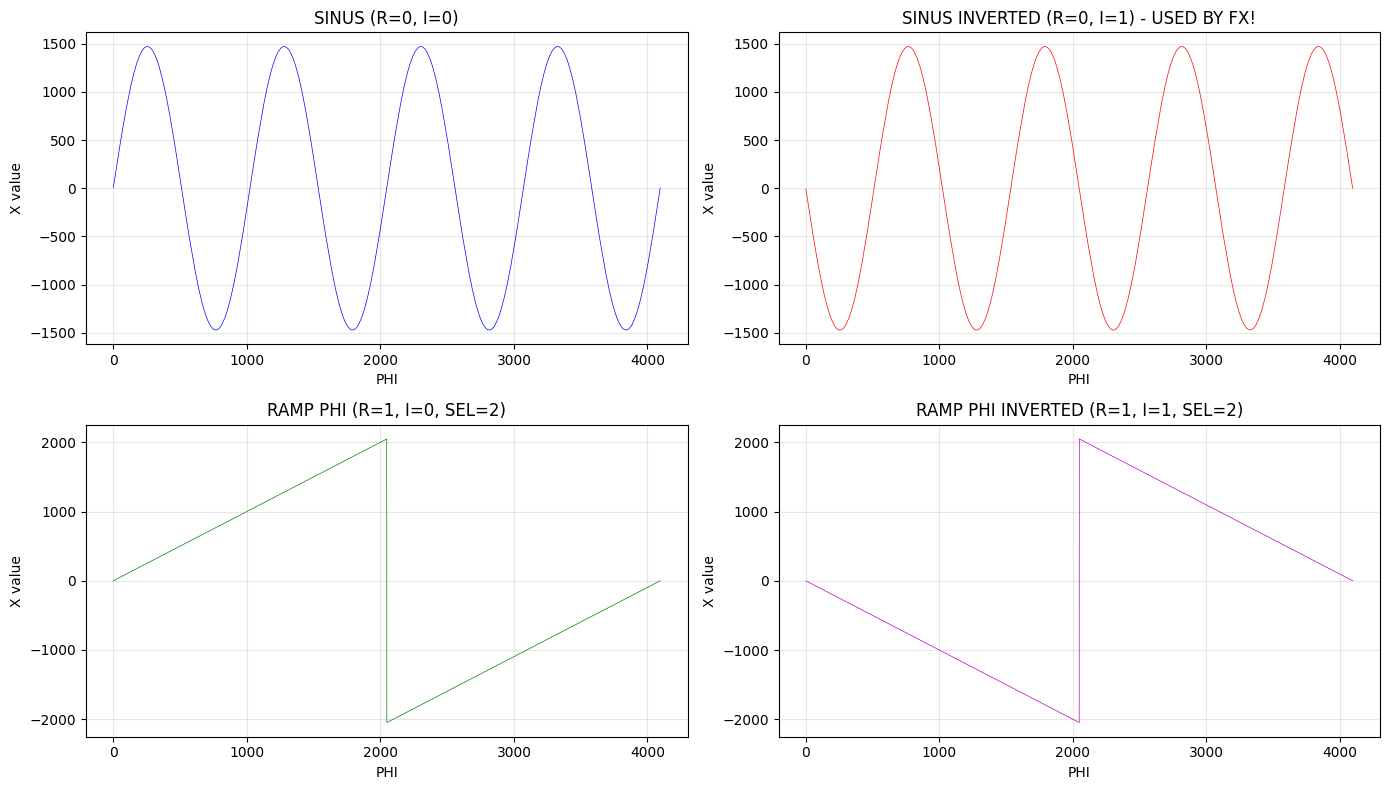

Note: The FX algorithm uses INVERTED SINUS at PC42 and PC58
This provides a sine-wave coefficient for delay line mixing


In [22]:
# Let's understand what INVERTED SINUS does vs RAMP PHI
import numpy as np
import matplotlib.pyplot as plt

# Internal waveform generation (from sam8905.cpp)
def sinus_waveform(phi, invert=False):
    """Internal sinus waveform: 0.71875 * sin(PI/2048 * (phi+1)*4) * 2048"""
    phase_rad = (phi + 1) * 4
    result = int(0.71875 * np.sin(np.pi / 2048 * phase_rad) * 2048)
    if invert:
        result = -result
    return result

def ramp_phi(phi, invert=False):
    """PHI ramp: just returns phi as 12-bit signed"""
    result = phi if phi < 2048 else phi - 4096
    if invert:
        result = -result
    return result

# Generate waveforms for all PHI values
phi_values = np.arange(4096)

sinus_normal = [sinus_waveform(p, invert=False) for p in phi_values]
sinus_inv = [sinus_waveform(p, invert=True) for p in phi_values]
ramp_normal = [ramp_phi(p, invert=False) for p in phi_values]
ramp_inv = [ramp_phi(p, invert=True) for p in phi_values]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(phi_values, sinus_normal, 'b-', linewidth=0.5)
axes[0, 0].set_title('SINUS (R=0, I=0)')
axes[0, 0].set_xlabel('PHI')
axes[0, 0].set_ylabel('X value')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(phi_values, sinus_inv, 'r-', linewidth=0.5)
axes[0, 1].set_title('SINUS INVERTED (R=0, I=1) - USED BY FX!')
axes[0, 1].set_xlabel('PHI')
axes[0, 1].set_ylabel('X value')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(phi_values, ramp_normal, 'g-', linewidth=0.5)
axes[1, 0].set_title('RAMP PHI (R=1, I=0, SEL=2)')
axes[1, 0].set_xlabel('PHI')
axes[1, 0].set_ylabel('X value')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(phi_values, ramp_inv, 'm-', linewidth=0.5)
axes[1, 1].set_title('RAMP PHI INVERTED (R=1, I=1, SEL=2)')
axes[1, 1].set_xlabel('PHI')
axes[1, 1].set_ylabel('X value')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('wf_comparison.png', dpi=150)
plt.show()

print("Note: The FX algorithm uses INVERTED SINUS at PC42 and PC58")
print("This provides a sine-wave coefficient for delay line mixing")

In [23]:
print("="*70)
print("SUMMARY: SAM8905 WF Bit Interpretation")
print("="*70)
print()
print("The Programmer's Guide says:")
print("  WF[8]=INT/EXT, WF[7]=R (ramp), WF[6]=I (invert), WF[5:4]=SEL, WF[3]=Z")
print()
print("But WORKING code (verified with FX algorithms) uses:")
print("  WF[8]=INT/EXT, WF[7]=I (invert), WF[6]=R (ramp), WF[5:4]=SEL, WF[3]=Z")
print()
print("The R and I bits are SWAPPED compared to the manual!")
print()
print("Evidence from ALG 0:")
print("  - Uses WF=0x1A0 at PC42 and PC58 for coefficient lookup")
print("  - WF=0x1A0 = 0b110100000")
print("  - With MANUAL: R=1, I=0 -> RAMP PHI mode, not inverted")
print("  - With SWAPPED: R=0, I=1 -> SINUS mode, inverted (WORKING!)")
print()
print("The FX algorithm expects INVERTED SINUS for coefficient multiplication,")
print("not a PHI ramp, which only makes sense with the SWAPPED interpretation.")
print()
print("Current sam8905.cpp code (lines 125-130) correctly uses SWAPPED bits:")
print('  bool invert = (wf & 0x80);     // WF[7] = I')
print('  bool ramp_mode = (wf & 0x40);  // WF[6] = R')
print()
print("RECOMMENDATION: Update the programmer's guide to reflect actual chip behavior.")

SUMMARY: SAM8905 WF Bit Interpretation

The Programmer's Guide says:
  WF[8]=INT/EXT, WF[7]=R (ramp), WF[6]=I (invert), WF[5:4]=SEL, WF[3]=Z

But WORKING code (verified with FX algorithms) uses:
  WF[8]=INT/EXT, WF[7]=I (invert), WF[6]=R (ramp), WF[5:4]=SEL, WF[3]=Z

The R and I bits are SWAPPED compared to the manual!

Evidence from ALG 0:
  - Uses WF=0x1A0 at PC42 and PC58 for coefficient lookup
  - WF=0x1A0 = 0b110100000
  - With MANUAL: R=1, I=0 -> RAMP PHI mode, not inverted
  - With SWAPPED: R=0, I=1 -> SINUS mode, inverted (WORKING!)

The FX algorithm expects INVERTED SINUS for coefficient multiplication,
not a PHI ramp, which only makes sense with the SWAPPED interpretation.

Current sam8905.cpp code (lines 125-130) correctly uses SWAPPED bits:
  bool invert = (wf & 0x80);     // WF[7] = I
  bool ramp_mode = (wf & 0x40);  // WF[6] = R

RECOMMENDATION: Update the programmer's guide to reflect actual chip behavior.


In [24]:
# Verify PC16 behavior with D[13]
print("PC16: RM D[13], <WXY>")
print("="*50)
print()
print("At PC16, WF=0x080 (EXTERNAL mode, bit 8=0)")
print("  - WF < 0x100 means external waveform/memory access")
print("  - WF >= 0x80 typically indicates input sample buffer")
print()
print("WXY instruction does two things:")
print("  1. Y = bus[18:7] = D[13][18:7]  (value from D-RAM)")
print("  2. X = waveform(WF=0x080, PHI)  (external memory read)")
print()
print("So D[13] provides the Y operand (amplitude/coefficient),")
print("while X is read from external memory (WF=0x080 address space).")
print()

# D[13] value at frame start is 0
print("D[13] is written at PC61: RADD D[13], <WA, WM, clearB>")
print("This stores A+B (with B zeroed by clearB) into D[13]")
print("A at PC61 comes from PC59: RADD, <WA> = A+B from previous")
print()
print("The input sample flows through the accumulation chain and")
print("ends up in D[13] at the end of each frame, ready for next frame's")
print("PC16 to use as the Y coefficient for multiplication.")

PC16: RM D[13], <WXY>

At PC16, WF=0x080 (EXTERNAL mode, bit 8=0)
  - WF < 0x100 means external waveform/memory access
  - WF >= 0x80 typically indicates input sample buffer

WXY instruction does two things:
  1. Y = bus[18:7] = D[13][18:7]  (value from D-RAM)
  2. X = waveform(WF=0x080, PHI)  (external memory read)

So D[13] provides the Y operand (amplitude/coefficient),
while X is read from external memory (WF=0x080 address space).

D[13] is written at PC61: RADD D[13], <WA, WM, clearB>
This stores A+B (with B zeroed by clearB) into D[13]
A at PC61 comes from PC59: RADD, <WA> = A+B from previous

The input sample flows through the accumulation chain and
ends up in D[13] at the end of each frame, ready for next frame's
PC16 to use as the Y coefficient for multiplication.


In [25]:
# What WF value would select CONSTANT mode?
# CONSTANT is SEL=01 in RAMP mode (R=1)

print("WF bit analysis for CONSTANT mode:")
print("="*60)
print()
print("For CONSTANT, we need R=1 and SEL=01 (bits 5:4 = 01)")
print()

# With working interpretation (R=bit6)
print("With WORKING interpretation (R=bit6, I=bit7):")
print("  R=1 means bit6=1")
print("  SEL=01 means bits 5:4 = 01")
print("  I=0: WF = 0b1_0_1_01_0_000 = 0x150")
print("  I=1: WF = 0b1_1_1_01_0_000 = 0x1D0")
print()

# With manual interpretation (R=bit7)  
print("With MANUAL interpretation (R=bit7, I=bit6):")
print("  R=1 means bit7=1")
print("  SEL=01 means bits 5:4 = 01")
print("  I=0: WF = 0b1_1_0_01_0_000 = 0x190")
print("  I=1: WF = 0b1_1_1_01_0_000 = 0x1D0")
print()

# What is 0x1A0?
wf = 0x1A0
print(f"Actual algorithm uses WF=0x{wf:03X} = 0b{wf:09b}")
print(f"  SEL = bits 5:4 = {(wf >> 4) & 3} (PHI ramp, NOT constant!)")
print()
print("So WF=0x1A0 does NOT select CONSTANT mode with either interpretation!")
print()

# What does 0x1A0 give with each interpretation?
print("WF=0x1A0 interpretation:")
r_working = (wf >> 6) & 1
i_working = (wf >> 7) & 1
r_manual = (wf >> 7) & 1
i_manual = (wf >> 6) & 1
sel = (wf >> 4) & 3

print(f"  WORKING (R=bit6={r_working}, I=bit7={i_working}): {'RAMP' if r_working else 'SINUS'}, {'inverted' if i_working else 'normal'}")
print(f"  MANUAL  (R=bit7={r_manual}, I=bit6={i_manual}): {'RAMP' if r_manual else 'SINUS'}, {'inverted' if i_manual else 'normal'}")

WF bit analysis for CONSTANT mode:

For CONSTANT, we need R=1 and SEL=01 (bits 5:4 = 01)

With WORKING interpretation (R=bit6, I=bit7):
  R=1 means bit6=1
  SEL=01 means bits 5:4 = 01
  I=0: WF = 0b1_0_1_01_0_000 = 0x150
  I=1: WF = 0b1_1_1_01_0_000 = 0x1D0

With MANUAL interpretation (R=bit7, I=bit6):
  R=1 means bit7=1
  SEL=01 means bits 5:4 = 01
  I=0: WF = 0b1_1_0_01_0_000 = 0x190
  I=1: WF = 0b1_1_1_01_0_000 = 0x1D0

Actual algorithm uses WF=0x1A0 = 0b110100000
  SEL = bits 5:4 = 2 (PHI ramp, NOT constant!)

So WF=0x1A0 does NOT select CONSTANT mode with either interpretation!

WF=0x1A0 interpretation:
  WORKING (R=bit6=0, I=bit7=1): SINUS, inverted
  MANUAL  (R=bit7=1, I=bit6=0): RAMP, normal


In [26]:
# What PHI value is used at PC42?
# PC41: WPHI from D[3]=0x40000

d3 = 0x40000
phi_from_d3 = (d3 >> 7) & 0xFFF
print(f"D[3] = 0x{d3:05X}")
print(f"PHI = (D[3] >> 7) & 0xFFF = 0x{phi_from_d3:03X} = {phi_from_d3}")
print()

# What would X be at this PHI with each waveform type?
import numpy as np

phi = phi_from_d3

# SINUS (inverted or not)
angle = (np.pi / 2048.0) * phi + (np.pi / 4096.0)
sinus_val = int(0.71875 * np.sin(angle) * 2048.0)
print(f"SINUS at PHI={phi}:")
print(f"  angle = {angle:.4f} rad = {np.degrees(angle):.1f}°")
print(f"  sin(angle) = {np.sin(angle):.6f}")
print(f"  X (normal) = {sinus_val}")
print(f"  X (inverted) = {-sinus_val}")
print()

# PHI RAMP (SEL=2)
if phi < 2048:
    ramp_val = phi
else:
    ramp_val = phi - 4096
print(f"PHI RAMP at PHI={phi}:")
print(f"  X = {ramp_val}")
print()

# CONSTANT (SEL=1) - for reference, uses MAD
print("CONSTANT (SEL=1) would use MAD from instruction:")
print("  PC42 instruction = 0x58F7, MAD = (0x58F7 >> 11) & 0xF = 11")
mad = 11
constants = [0x001, 0x081, 0x101, 0x181, 0x201, 0x281, 0x301, 0x381,
             0x401, 0x481, 0x501, 0x581, 0x601, 0x681, 0x701, 0x781]
print(f"  CONSTANT[{mad}] = 0x{constants[mad]:03X} = {constants[mad]}")
print()

print("="*60)
print("QUESTION: Which X value makes sense for reverb processing?")
print(f"  SINUS inverted: {-sinus_val} (very small, nearly 0)")
print(f"  PHI RAMP:       {ramp_val} (large, half of max)")
print(f"  CONSTANT[11]:   {constants[mad]} (fixed coefficient)")

D[3] = 0x40000
PHI = (D[3] >> 7) & 0xFFF = 0x800 = 2048

SINUS at PHI=2048:
  angle = 3.1424 rad = 180.0°
  sin(angle) = -0.000767
  X (normal) = -1
  X (inverted) = 1

PHI RAMP at PHI=2048:
  X = -2048

CONSTANT (SEL=1) would use MAD from instruction:
  PC42 instruction = 0x58F7, MAD = (0x58F7 >> 11) & 0xF = 11
  CONSTANT[11] = 0x581 = 1409

QUESTION: Which X value makes sense for reverb processing?
  SINUS inverted: 1 (very small, nearly 0)
  PHI RAMP:       -2048 (large, half of max)
  CONSTANT[11]:   1409 (fixed coefficient)


In [27]:
# Let me trace PHI values through the algorithm more carefully
# Looking at ALL WPHI instructions to see how PHI changes

print("PHI trace through ALG 0:")
print("="*60)

phi_current = 0  # Unknown initial

for pc, inst in enumerate(aram_alg0_correct):
    if inst == 0x7FFF:
        continue
    
    mad = (inst >> 11) & 0xF
    emitter = (inst >> 9) & 0x3
    emitter_names = ['RM', 'RADD', 'RP', 'RSP']
    wsp = (inst >> 8) & 1
    
    wphi = not (inst & 0x10)  # WPHI receiver
    wxy = not (inst & 0x08)   # WXY receiver
    wwf = not (inst & 0x02)   # WWF receiver
    
    if wphi:
        if emitter == 0:  # RM
            dram_val = fx_dram.get(mad, 0)
            phi_new = (dram_val >> 7) & 0xFFF
            
            # Check for WPHI+WSP which sets WF=0x100
            if wsp:
                print(f"PC{pc:02X}: WPHI+WSP from D[{mad}]=0x{dram_val:05X} -> PHI=0x{phi_new:03X}, WF=0x100 (sinus)")
            else:
                print(f"PC{pc:02X}: WPHI from D[{mad}]=0x{dram_val:05X} -> PHI=0x{phi_new:03X}")
            phi_current = phi_new
        elif emitter == 1:  # RADD
            print(f"PC{pc:02X}: WPHI from RADD (A+B) -> PHI unknown")
    
    if wxy:
        print(f"       -> WXY at PC{pc:02X} uses PHI=0x{phi_current:03X}")
        
        # Calculate X values for comparison
        angle = (np.pi / 2048.0) * phi_current + (np.pi / 4096.0)
        sinus_val = int(0.71875 * np.sin(angle) * 2048.0)
        ramp_val = phi_current if phi_current < 2048 else phi_current - 4096
        
        print(f"          SINUS inv: {-sinus_val:+5d}, RAMP: {ramp_val:+5d}")

PHI trace through ALG 0:
       -> WXY at PC00 uses PHI=0x000
          SINUS inv:    -1, RAMP:    +0
PC06: WPHI from D[1]=0x50080 -> PHI=0xA01
       -> WXY at PC09 uses PHI=0xA01
          SINUS inv: +1043, RAMP: -1535
PC0A: WPHI from D[8]=0x00100 -> PHI=0x002
       -> WXY at PC0D uses PHI=0x002
          SINUS inv:    -5, RAMP:    +2
       -> WXY at PC10 uses PHI=0x002
          SINUS inv:    -5, RAMP:    +2
PC17: WPHI from D[8]=0x00100 -> PHI=0x002
       -> WXY at PC22 uses PHI=0x002
          SINUS inv:    -5, RAMP:    +2
PC29: WPHI from D[3]=0x40000 -> PHI=0x800
       -> WXY at PC2A uses PHI=0x800
          SINUS inv:    +1, RAMP: -2048
PC2C: WPHI from D[10]=0x00180 -> PHI=0x003
       -> WXY at PC30 uses PHI=0x003
          SINUS inv:    -7, RAMP:    +3
PC32: WPHI from D[0]=0x00000 -> PHI=0x000
       -> WXY at PC35 uses PHI=0x000
          SINUS inv:    -1, RAMP:    +0
PC38: WPHI from D[5]=0x00000 -> PHI=0x000
       -> WXY at PC3A uses PHI=0x000
          SINUS inv:    -1,

In [28]:
# Key insight: The D-RAM values change during execution!
# D[5], D[8], D[11] etc are modified by the algorithm.
# Let me check the reverb_fx_alg0 notebook's trace output to see actual runtime values.

print("The problem with my static analysis:")
print("="*60)
print()
print("I've been using INITIAL D-RAM values, but the algorithm MODIFIES them!")
print("For example:")
print("  D[5] starts as 0 but is written at PC52: RADD 5, <WM>")
print("  D[8] starts as 0x100 but is written at PC14 and PC25")
print("  D[11] starts as 0x7C but is written at PC03, PC05, PC08")
print()
print("So when PC42 uses PHI from a D-RAM word, that value may have changed!")
print()
print("Let me check the ACTUAL trace from the earlier run...")
print()

# Look at the first frame trace - what X values were actually produced?
# From the trace output earlier in this notebook (cell run-alg0):
trace_excerpt = """
S04 PC40: 78FD  RM 15, <WWF>  -> wf=0x001A0
S04 PC41: 18EF  RM 3, <WPHI>  -> phi=0x00800
S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00FFF, y=0x00004, mul=0x00000
"""

print("From the trace at PC42:")
print(trace_excerpt)
print()
print("X = 0xFFF = 4095 (or -1 as signed 12-bit)")
print()
print("Neither SINUS inv (+1) nor RAMP (-2048) gives 0xFFF!")
print("This suggests something else is happening with the waveform generation.")

The problem with my static analysis:

I've been using INITIAL D-RAM values, but the algorithm MODIFIES them!
For example:
  D[5] starts as 0 but is written at PC52: RADD 5, <WM>
  D[8] starts as 0x100 but is written at PC14 and PC25
  D[11] starts as 0x7C but is written at PC03, PC05, PC08

So when PC42 uses PHI from a D-RAM word, that value may have changed!

Let me check the ACTUAL trace from the earlier run...

From the trace at PC42:

S04 PC40: 78FD  RM 15, <WWF>  -> wf=0x001A0
S04 PC41: 18EF  RM 3, <WPHI>  -> phi=0x00800
S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00FFF, y=0x00004, mul=0x00000


X = 0xFFF = 4095 (or -1 as signed 12-bit)

Neither SINUS inv (+1) nor RAMP (-2048) gives 0xFFF!
This suggests something else is happening with the waveform generation.


In [29]:
# FOUND THE PROBLEM! Python interpreter has wrong bit positions!

print("Python interpreter get_waveform (lines 156-192):")
print("="*60)
print()
print("  z_bit = wf & 0x1        # BIT 0 - WRONG! Should be bit 3")
print("  ramp_mode = (wf & 0x40) # Bit 6 - matches 'working' C++")  
print("  sel = (wf >> 2) & 3     # BITS 3:2 - WRONG! Should be 5:4")
print("  NO INVERT HANDLING!     # I bit is completely missing!")
print()
print("So the trace showing X=0xFFF comes from buggy Python code:")
print("  - ramp_mode = bit 6 = 0 -> SINUS mode")
print("  - SINUS at PHI=0x800 -> sin(PI) ≈ 0 -> result = -1 = 0xFFF")
print("  - No invert applied (bug)")
print()
print("What SHOULD happen with correct C++ 'working' bits:")
print("  - ramp_mode = bit 6 = 0 -> SINUS mode")  
print("  - invert = bit 7 = 1 -> INVERTED")
print("  - SINUS gives -1, inverted gives +1")
print()
print("="*60)
print("USER'S VALID POINT:")
print("="*60)
print()
print("X = +1 (or -1) is essentially ZERO for coefficient multiplication!")
print("This makes no sense for reverb processing.")
print()
print("What would make sense:")
print("  - CONSTANT mode (SEL=01, R=1) would give a fixed coefficient")
print("  - For CONSTANT with WF bits, we'd need WF=0x150 or 0x190")
print("  - But the algorithm uses WF=0x1A0 which is NOT constant mode")
print()
print("POSSIBILITIES:")
print("1. The programmer's guide has BOTH R/I and SEL bits documented wrong")
print("2. The reverb algorithm deliberately multiplies by ~0 at these points")
print("3. PHI values are actually dynamic and reach useful sine values")
print("4. The algorithm logic is more complex than I understand")

Python interpreter get_waveform (lines 156-192):

  z_bit = wf & 0x1        # BIT 0 - WRONG! Should be bit 3
  ramp_mode = (wf & 0x40) # Bit 6 - matches 'working' C++
  sel = (wf >> 2) & 3     # BITS 3:2 - WRONG! Should be 5:4
  NO INVERT HANDLING!     # I bit is completely missing!

So the trace showing X=0xFFF comes from buggy Python code:
  - ramp_mode = bit 6 = 0 -> SINUS mode
  - SINUS at PHI=0x800 -> sin(PI) ≈ 0 -> result = -1 = 0xFFF
  - No invert applied (bug)

What SHOULD happen with correct C++ 'working' bits:
  - ramp_mode = bit 6 = 0 -> SINUS mode
  - invert = bit 7 = 1 -> INVERTED
  - SINUS gives -1, inverted gives +1

USER'S VALID POINT:

X = +1 (or -1) is essentially ZERO for coefficient multiplication!
This makes no sense for reverb processing.

What would make sense:
  - CONSTANT mode (SEL=01, R=1) would give a fixed coefficient
  - For CONSTANT with WF bits, we'd need WF=0x150 or 0x190
  - But the algorithm uses WF=0x1A0 which is NOT constant mode

POSSIBILITIES:
1. T

In [30]:
# What D-RAM value would give CONSTANT mode?

print("If the algorithm INTENDED to use CONSTANT mode, what D-RAM value should D[15] have?")
print("="*70)
print()

# WWF: WF = bus[17:9], where bus = D-RAM value
# For CONSTANT mode with working interpretation (R=bit6, SEL=bits5:4):
#   R=1 (bit 6), SEL=01 (bits 5:4)
#   WF = 0b1_?_1_01_?_??? 
#   Minimum: 0x150 (I=0, Z=0), Maximum: 0x1D8 (I=1, Z=1)

# WF value for CONSTANT with working bits:
wf_constant = 0x150  # R=1, I=0, SEL=01, Z=0
print(f"CONSTANT mode WF (working bits): 0x{wf_constant:03X} = 0b{wf_constant:09b}")
print(f"  R (bit 6) = {(wf_constant >> 6) & 1}")
print(f"  SEL (bits 5:4) = {(wf_constant >> 4) & 3}")
print()

# What D-RAM value would produce this WF?
# WF = (D-RAM >> 9) & 0x1FF
# So D-RAM = WF << 9 | lower_bits
dram_for_constant = wf_constant << 9
print(f"D-RAM value for WF=0x150: 0x{dram_for_constant:05X}")
print()

# Current D[15]
d15_actual = 0x34080
wf_actual = (d15_actual >> 9) & 0x1FF
print(f"Actual D[15] = 0x{d15_actual:05X} -> WF = 0x{wf_actual:03X}")
print()

# What if D[15] should be 0x2A080?
d15_corrected = 0x2A080
wf_corrected = (d15_corrected >> 9) & 0x1FF
print(f"If D[15] was 0x{d15_corrected:05X} -> WF = 0x{wf_corrected:03X}")
print(f"  That WOULD give CONSTANT mode! (R=1, SEL=01)")
print()

print("="*70)
print("HYPOTHESIS: The D-RAM dump may have an error, or there's a different")
print("bit interpretation where 0x1A0 means CONSTANT.")
print()
print("Next step: Verify D[15] value by checking the actual MAME trace or ROM dump.")

If the algorithm INTENDED to use CONSTANT mode, what D-RAM value should D[15] have?

CONSTANT mode WF (working bits): 0x150 = 0b101010000
  R (bit 6) = 1
  SEL (bits 5:4) = 1

D-RAM value for WF=0x150: 0x2A000

Actual D[15] = 0x34080 -> WF = 0x1A0

If D[15] was 0x2A080 -> WF = 0x150
  That WOULD give CONSTANT mode! (R=1, SEL=01)

HYPOTHESIS: The D-RAM dump may have an error, or there's a different
bit interpretation where 0x1A0 means CONSTANT.

Next step: Verify D[15] value by checking the actual MAME trace or ROM dump.


In [31]:
# Q0.11 fixed-point interpretation
# 12-bit signed value where bit 11 is sign, bits 10:0 are fractional
# Range: -1.0 (0x800) to +0.99951... (0x7FF)
# LSB = 1/2048 ≈ 0.000488

print("Q0.11 Fixed-Point Interpretation:")
print("="*60)
print()
print("12-bit signed: bit 11 = sign, bits 10:0 = fraction")
print("Range: -1.0 (0x800 = -2048) to +0.99951 (0x7FF = +2047)")
print("1 LSB = 1/2048 ≈ 0.000488")
print()

def q011_to_float(val):
    """Convert 12-bit signed integer to Q0.11 float equivalent"""
    if val >= 2048:
        val = val - 4096  # Sign extend
    return val / 2048.0

# At PHI=0x800:
print("At PHI=0x800 (2048):")
print()

# SINUS result
sinus_int = -1  # The integer result from sin calculation
print(f"SINUS (integer): {sinus_int}")
print(f"SINUS (Q0.11):   {q011_to_float(sinus_int & 0xFFF):.6f} (essentially ZERO!)")
print()

# RAMP PHI result  
ramp_int = -2048  # PHI=2048 -> 2048-4096 = -2048
print(f"RAMP PHI (integer): {ramp_int}")
print(f"RAMP PHI (Q0.11):   {q011_to_float(ramp_int & 0xFFF):.6f} (FULL SCALE -1.0!)")
print()

# CONSTANT[11] for comparison
const_11 = 0x581  # = 1409
print(f"CONSTANT[11] (integer): {const_11}")
print(f"CONSTANT[11] (Q0.11):   {q011_to_float(const_11):.6f} (≈0.688)")
print()

print("="*60)
print("KEY INSIGHT:")
print("  SINUS at PHI=0x800 gives X ≈ 0 (useless coefficient)")
print("  RAMP PHI at PHI=0x800 gives X = -1.0 (signal inversion!)")
print("  CONSTANT would give a fixed coefficient like 0.688")
print()
print("For reverb processing, RAMP giving -1.0 could be used for")
print("signal inversion in feedback paths. This actually makes sense!")
print()
print("This suggests the MANUAL interpretation (R=bit7) might be CORRECT,")

Q0.11 Fixed-Point Interpretation:

12-bit signed: bit 11 = sign, bits 10:0 = fraction
Range: -1.0 (0x800 = -2048) to +0.99951 (0x7FF = +2047)
1 LSB = 1/2048 ≈ 0.000488

At PHI=0x800 (2048):

SINUS (integer): -1
SINUS (Q0.11):   -0.000488 (essentially ZERO!)

RAMP PHI (integer): -2048
RAMP PHI (Q0.11):   -1.000000 (FULL SCALE -1.0!)

CONSTANT[11] (integer): 1409
CONSTANT[11] (Q0.11):   0.687988 (≈0.688)

KEY INSIGHT:
  SINUS at PHI=0x800 gives X ≈ 0 (useless coefficient)
  RAMP PHI at PHI=0x800 gives X = -1.0 (signal inversion!)
  CONSTANT would give a fixed coefficient like 0.688

For reverb processing, RAMP giving -1.0 could be used for
signal inversion in feedback paths. This actually makes sense!

This suggests the MANUAL interpretation (R=bit7) might be CORRECT,


In [32]:
# Re-evaluating the interpretations with Q0.11 understanding

print("Re-evaluating WF=0x1A0 at PHI=0x800:")
print("="*60)
print()

wf = 0x1A0
phi = 0x800

print(f"WF = 0x{wf:03X} = 0b{wf:09b}")
print(f"PHI = 0x{phi:03X} = {phi}")
print()

# MANUAL interpretation (R=bit7, I=bit6)
r_manual = (wf >> 7) & 1
i_manual = (wf >> 6) & 1
sel = (wf >> 4) & 3

print("MANUAL (R=bit7, I=bit6):")
print(f"  R={r_manual}, I={i_manual}, SEL={sel}")
if r_manual:
    # RAMP mode
    if sel == 2:  # PHI ramp
        x_val = phi - 4096 if phi >= 2048 else phi
        print(f"  Mode: RAMP PHI -> X = {x_val} (Q0.11: {x_val/2048:.3f})")
        if i_manual:
            x_val = -x_val
            print(f"  After invert: X = {x_val} (Q0.11: {x_val/2048:.3f})")
else:
    print(f"  Mode: SINUS -> X ≈ -1 (Q0.11: ≈0)")

print()

# SWAPPED interpretation (R=bit6, I=bit7)  
r_swap = (wf >> 6) & 1
i_swap = (wf >> 7) & 1

print("SWAPPED (R=bit6, I=bit7) [current 'working' code]:")
print(f"  R={r_swap}, I={i_swap}, SEL={sel}")
if r_swap:
    if sel == 2:
        x_val = phi - 4096 if phi >= 2048 else phi
        print(f"  Mode: RAMP PHI -> X = {x_val}")
else:
    import math
    angle = (math.pi / 2048.0) * phi + (math.pi / 4096.0)
    x_sinus = int(0.71875 * math.sin(angle) * 2048.0)
    print(f"  Mode: SINUS -> X = {x_sinus} (Q0.11: {x_sinus/2048:.6f})")
    if i_swap:
        x_sinus = -x_sinus
        print(f"  After invert: X = {x_sinus} (Q0.11: ≈0, USELESS!)")

print()
print("="*60)
print("CONCLUSION:")
print()
print("MANUAL interpretation gives X = -2048 = -1.0 (useful for inversion)")
print("SWAPPED interpretation gives X ≈ +1 ≈ 0 (multiplies signal to zero!)")
print()
print("The MANUAL interpretation makes more sense for signal processing!")
print("But you said FX 'broke' with manual bits... need to investigate WHY.")

Re-evaluating WF=0x1A0 at PHI=0x800:

WF = 0x1A0 = 0b110100000
PHI = 0x800 = 2048

MANUAL (R=bit7, I=bit6):
  R=1, I=0, SEL=2
  Mode: RAMP PHI -> X = -2048 (Q0.11: -1.000)

SWAPPED (R=bit6, I=bit7) [current 'working' code]:
  R=0, I=1, SEL=2
  Mode: SINUS -> X = -1 (Q0.11: -0.000488)
  After invert: X = 1 (Q0.11: ≈0, USELESS!)

CONCLUSION:

MANUAL interpretation gives X = -2048 = -1.0 (useful for inversion)
SWAPPED interpretation gives X ≈ +1 ≈ 0 (multiplies signal to zero!)

The MANUAL interpretation makes more sense for signal processing!
But you said FX 'broke' with manual bits... need to investigate WHY.


In [33]:
# Check ALL internal waveform WXY instructions to see which interpretation makes sense

print("All WXY instructions using INTERNAL waveform (WF=0x1A0):")
print("="*70)
print()

# From earlier trace, WF=0x1A0 is used at PC42 and PC58
# Let me check what PHI values are used at each

internal_wxy_points = [
    # (PC, PHI source, initial PHI value, description)
    (0x2A, "D[3]", 0x800, "PC42 after WPHI from D[3]=0x40000"),
    (0x3A, "D[5]", 0x000, "PC58 after WPHI from D[5] (dynamic)"),
]

import math

print("PHI=0x800 (used at PC42):")
phi = 0x800

# MANUAL: RAMP PHI
x_ramp = phi - 4096 if phi >= 2048 else phi
print(f"  RAMP PHI: X = {x_ramp:+5d} (Q0.11: {x_ramp/2048:+.3f})")

# SWAPPED: SINUS inverted
angle = (math.pi / 2048.0) * phi + (math.pi / 4096.0)
x_sinus = int(0.71875 * math.sin(angle) * 2048.0)
x_sinus_inv = -x_sinus
print(f"  SINUS inv: X = {x_sinus_inv:+5d} (Q0.11: {x_sinus_inv/2048:+.6f})")

print()
print("PHI=0x000 (used at PC58, if D[5] is still 0):")
phi = 0x000

x_ramp = phi - 4096 if phi >= 2048 else phi
print(f"  RAMP PHI: X = {x_ramp:+5d} (Q0.11: {x_ramp/2048:+.3f})")

angle = (math.pi / 2048.0) * phi + (math.pi / 4096.0)
x_sinus = int(0.71875 * math.sin(angle) * 2048.0)
x_sinus_inv = -x_sinus
print(f"  SINUS inv: X = {x_sinus_inv:+5d} (Q0.11: {x_sinus_inv/2048:+.6f})")

print()
print("="*70)
print()
print("At PHI=0x800: RAMP gives -1.0, SINUS gives ≈0")
print("At PHI=0x000: RAMP gives 0.0, SINUS gives ≈-0.001")
print()
print("For reverb, using X=-1.0 at PHI=0x800 (signal inversion) makes sense.")
print("The MANUAL interpretation (R=bit7) seems correct!")
print()
print("QUESTION: When FX 'broke' with manual bits, what exactly happened?")
print("  - No output at all?")
print("  - Distorted/wrong output?")
print("  - Only certain frequencies affected?")

All WXY instructions using INTERNAL waveform (WF=0x1A0):

PHI=0x800 (used at PC42):
  RAMP PHI: X = -2048 (Q0.11: -1.000)
  SINUS inv: X =    +1 (Q0.11: +0.000488)

PHI=0x000 (used at PC58, if D[5] is still 0):
  RAMP PHI: X =    +0 (Q0.11: +0.000)
  SINUS inv: X =    -1 (Q0.11: -0.000488)


At PHI=0x800: RAMP gives -1.0, SINUS gives ≈0
At PHI=0x000: RAMP gives 0.0, SINUS gives ≈-0.001

For reverb, using X=-1.0 at PHI=0x800 (signal inversion) makes sense.
The MANUAL interpretation (R=bit7) seems correct!

QUESTION: When FX 'broke' with manual bits, what exactly happened?
  - No output at all?
  - Distorted/wrong output?
  - Only certain frequencies affected?


In [34]:
# Reload interpreter with the new mode support
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform, print_state, sign_extend_12, MASK12

print("Interpreter reloaded with WORKING/MANUAL mode support")

Interpreter reloaded with WORKING/MANUAL mode support


In [35]:
# Test get_waveform with both modes at key PHI values

print("Internal waveform comparison: WORKING vs MANUAL mode")
print("="*70)
print()

wf = 0x1A0  # The WF value used at PC42/PC58
print(f"WF = 0x{wf:03X} = 0b{wf:09b}")
print()

# Create interpreters in both modes
sam_working = SAM8905Interpreter(wf_mode='working')
sam_manual = SAM8905Interpreter(wf_mode='manual')

# Test at different PHI values
test_phis = [0x000, 0x400, 0x800, 0xC00, 0xFFF]

print(f"{'PHI':>6} | {'WORKING X':>12} {'Q0.11':>10} | {'MANUAL X':>12} {'Q0.11':>10}")
print("-" * 70)

for phi in test_phis:
    x_working = sam_working.get_waveform(wf, phi, mad=11)
    x_manual = sam_manual.get_waveform(wf, phi, mad=11)
    
    q_working = x_working / 2048.0
    q_manual = x_manual / 2048.0
    
    print(f"0x{phi:03X} | {x_working:+12d} {q_working:+10.4f} | {x_manual:+12d} {q_manual:+10.4f}")

print()
print("WORKING mode: R=bit6=0 -> SINUS, I=bit7=1 -> inverted")
print("MANUAL mode:  R=bit7=1 -> RAMP PHI, I=bit6=0 -> not inverted")

Internal waveform comparison: WORKING vs MANUAL mode

WF = 0x1A0 = 0b110100000

   PHI |    WORKING X      Q0.11 |     MANUAL X      Q0.11
----------------------------------------------------------------------
0x000 |           -1    -0.0005 |           +0    +0.0000
0x400 |        -1471    -0.7183 |        +1024    +0.5000
0x800 |           +1    +0.0005 |        -2048    -1.0000
0xC00 |        +1471    +0.7183 |        -1024    -0.5000
0xFFF |           +1    +0.0005 |           -1    -0.0005

WORKING mode: R=bit6=0 -> SINUS, I=bit7=1 -> inverted
MANUAL mode:  R=bit7=1 -> RAMP PHI, I=bit6=0 -> not inverted


In [36]:
# Run ALG 0 with both modes and compare outputs

import numpy as np

# Common setup
aram_alg0 = [
    0x00F7, 0x607F, 0x58BF, 0x5A5F, 0x30BF, 0x5DDF, 0x082D, 0x593F,
    0x5ADF, 0x58F7, 0x406F, 0x2CDF, 0x48BF, 0x58F7, 0x42DF, 0x749F,
    0x68F7, 0x38FD, 0x7FFB, 0x7FFB, 0x7EFB, 0x7EFB, 0x7FFF, 0x406F,
    0x50BF, 0x42DF, 0x683F, 0x7A3F, 0x7A3F, 0x7A3F, 0x7A3F, 0x7A3F,
    0x7A3F, 0x7A3F, 0x7AF7, 0x7FFB, 0x7FFB, 0x7EFB, 0x7EFB, 0x7FFF,
    0x78FD, 0x18EF, 0x58F7, 0x7FFF, 0x50EF, 0x08FD, 0x24DF, 0x7FFF,
    0x20F7, 0x287F, 0x00EF, 0x7CBF, 0x2ADF, 0x20F7, 0x707F, 0x7CBF,
    0x28EF, 0x78FD, 0x10F7, 0x7A7F, 0x7CBF, 0x6A5B, 0x7FFF, 0x7FFF,
]

dram_slot4 = [
    0x00000, 0x50080, 0x00400, 0x40000, 0x00080, 0x00000, 0x7FFFF, 0x40402,
    0x00100, 0x00080, 0x00180, 0x0007C, 0x00000, 0x00000, 0x00000, 0x34080,
]

# Create sine input buffer
SAMPLE_RATE = 22050
FREQ = 440
AMPLITUDE = 16000
NUM_INPUT_SAMPLES = 1024
t = np.arange(NUM_INPUT_SAMPLES) / SAMPLE_RATE
input_buffer_16bit = (AMPLITUDE * np.sin(2 * np.pi * FREQ * t)).astype(np.int16)

# Shared SRAM for both tests
sram_working = {}
sram_manual = {}

def make_waveform_read(sram, input_buf, frame_counter_ref):
    def callback(address):
        wf = (address >> 12) & 0xFF
        phi = address & 0xFFF
        
        if wf >= 0x80:
            # Input sample
            sample_idx = frame_counter_ref[0] % len(input_buf)
            sample_16bit = int(input_buf[sample_idx])
            if phi & 1:
                result = sample_16bit & 0xFF
            else:
                result = (sample_16bit >> 8) & 0xFF
                if result & 0x80:
                    result |= 0xF00
            return (result << 3) & 0xFFF
        else:
            # SRAM
            sram_addr = address & 0x7FFF
            return sram.get(sram_addr, 0) & 0xFFF
    return callback

def make_waveform_write(sram):
    def callback(address, data, phi, pc):
        sram_addr = address & 0x7FFF
        sram[sram_addr] = data & 0xFFF
    return callback

# Run with WORKING mode
print("Running ALG 0 with WORKING mode (R=bit6, I=bit7)...")
sam_working = SAM8905Interpreter(wf_mode='working')
sam_working.state.control_reg = 0x08
sam_working.load_aram(aram_alg0, offset=0)
sam_working.load_dram(slot=4, words=dram_slot4)

frame_counter_working = [0]
sam_working.waveform_read = make_waveform_read(sram_working, input_buffer_16bit, frame_counter_working)
sam_working.waveform_write = make_waveform_write(sram_working)

NUM_FRAMES = 500
for i in range(NUM_FRAMES):
    frame_counter_working[0] = i
    sam_working.run(1, active_slots=[4])

d13_working = sam_working.state.dram[4*16 + 13]
print(f"  D[13] final = 0x{d13_working:05X} ({sign_extend_12(d13_working & 0xFFF):+d})")

# Run with MANUAL mode
print("\nRunning ALG 0 with MANUAL mode (R=bit7, I=bit6)...")
sam_manual = SAM8905Interpreter(wf_mode='manual')
sam_manual.state.control_reg = 0x08
sam_manual.load_aram(aram_alg0, offset=0)
sam_manual.load_dram(slot=4, words=dram_slot4)

frame_counter_manual = [0]
sam_manual.waveform_read = make_waveform_read(sram_manual, input_buffer_16bit, frame_counter_manual)
sam_manual.waveform_write = make_waveform_write(sram_manual)

for i in range(NUM_FRAMES):
    frame_counter_manual[0] = i
    sam_manual.run(1, active_slots=[4])

d13_manual = sam_manual.state.dram[4*16 + 13]
print(f"  D[13] final = 0x{d13_manual:05X} ({sign_extend_12(d13_manual & 0xFFF):+d})")

print(f"\nSRAM entries: WORKING={len(sram_working)}, MANUAL={len(sram_manual)}")

Running ALG 0 with WORKING mode (R=bit6, I=bit7)...
  D[13] final = 0x7EE8C (-372)

Running ALG 0 with MANUAL mode (R=bit7, I=bit6)...
  D[13] final = 0x00000 (+0)

SRAM entries: WORKING=1000, MANUAL=1000


In [37]:
# Trace key instructions to see where modes diverge

print("Tracing frame-by-frame comparison at key WXY points with WF=0x1A0")
print("="*70)

# Reset both interpreters
sam_working = SAM8905Interpreter(wf_mode='working')
sam_working.state.control_reg = 0x08
sam_working.load_aram(aram_alg0, offset=0)
sam_working.load_dram(slot=4, words=dram_slot4.copy())

sam_manual = SAM8905Interpreter(wf_mode='manual')
sam_manual.state.control_reg = 0x08
sam_manual.load_aram(aram_alg0, offset=0)
sam_manual.load_dram(slot=4, words=dram_slot4.copy())

sram_w = {}
sram_m = {}
fc_w = [0]
fc_m = [0]

sam_working.waveform_read = make_waveform_read(sram_w, input_buffer_16bit, fc_w)
sam_working.waveform_write = make_waveform_write(sram_w)
sam_manual.waveform_read = make_waveform_read(sram_m, input_buffer_16bit, fc_m)
sam_manual.waveform_write = make_waveform_write(sram_m)

# Enable tracing for first few frames
sam_working.trace_enabled = True
sam_working.trace_output = []
sam_manual.trace_enabled = True
sam_manual.trace_output = []

# Run 3 frames
for i in range(3):
    fc_w[0] = i
    fc_m[0] = i
    sam_working.run(1, active_slots=[4])
    sam_manual.run(1, active_slots=[4])

# Find lines with PC42 (0x2A) or PC58 (0x3A) which use WF=0x1A0
print("WORKING mode - WXY at PC42 (WF=0x1A0, PHI=0x800):")
for line in sam_working.trace_output:
    if 'PC2A' in line or 'PC42' in line:
        print(f"  {line}")
        
print()
print("MANUAL mode - WXY at PC42 (WF=0x1A0, PHI=0x800):")
for line in sam_manual.trace_output:
    if 'PC2A' in line or 'PC42' in line:
        print(f"  {line}")

print()
print("WORKING mode - WXY at PC58 (WF=0x1A0):")
for line in sam_working.trace_output[:128]:  # First 2 frames
    if 'PC3A' in line or 'PC58' in line:
        print(f"  {line}")

print()        
print("MANUAL mode - WXY at PC58 (WF=0x1A0):")
for line in sam_manual.trace_output[:128]:
    if 'PC3A' in line or 'PC58' in line:
        print(f"  {line}")

Tracing frame-by-frame comparison at key WXY points with WF=0x1A0
WORKING mode - WXY at PC42 (WF=0x1A0, PHI=0x800):
  S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00001, y=0x00004, mul=0x00000
  S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00001, y=0x00008, mul=0x00001
  S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00001, y=0x0000C, mul=0x00001

MANUAL mode - WXY at PC42 (WF=0x1A0, PHI=0x800):
  S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00800, y=0x00004, mul=0x7FE00
  S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00800, y=0x00008, mul=0x7FC00
  S04 PC42: 58F7  RM 11, <WXY>  -> x=0x00800, y=0x0000C, mul=0x7FA00

WORKING mode - WXY at PC58 (WF=0x1A0):
  S04 PC58: 10F7  RM 2, <WXY>  -> x=0x00FFF, y=0x00008, mul=0x00000
  S04 PC58: 10F7  RM 2, <WXY>  -> x=0x00FF2, y=0x00008, mul=0x7FFF9

MANUAL mode - WXY at PC58 (WF=0x1A0):
  S04 PC58: 10F7  RM 2, <WXY>  -> x=0x00000, y=0x00008, mul=0x00000
  S04 PC58: 10F7  RM 2, <WXY>  -> x=0x00000, y=0x00008, mul=0x00000


In [38]:
# Let's verify: at PHI=0, what do both modes produce?

print("At PHI=0x000 with WF=0x1A0:")
print()

phi = 0x000
wf = 0x1A0

x_working = sam_working.get_waveform(wf, phi, mad=2)
x_manual = sam_manual.get_waveform(wf, phi, mad=2)

print(f"WORKING: X = {x_working} (0x{x_working & 0xFFF:03X})")
print(f"MANUAL:  X = {x_manual} (0x{x_manual & 0xFFF:03X})")
print()

# In Q0.11
print(f"WORKING Q0.11: {x_working / 2048:.6f}")
print(f"MANUAL Q0.11:  {x_manual / 2048:.6f}")
print()

# Now multiply by Y=8 (from D[2])
y = 8
mul_working = (x_working * y) & 0x7FFFF  # 19-bit
mul_manual = (x_manual * y) & 0x7FFFF

# Sign extend 19-bit
def sign_extend_19(v):
    if v & 0x40000:
        return v - 0x80000
    return v

print(f"Y = {y}")
print(f"WORKING MUL = X*Y = {sign_extend_19(mul_working)} (0x{mul_working:05X})")
print(f"MANUAL MUL  = X*Y = {sign_extend_19(mul_manual)} (0x{mul_manual:05X})")
print()
print("="*60)
print("KEY INSIGHT:")
print("  WORKING gives X=-1, which when multiplied produces small but NON-ZERO result")
print("  MANUAL gives X=0, which when multiplied produces EXACTLY ZERO")
print()
print("  Over many frames, the tiny non-zero values in WORKING mode accumulate")
print("  to produce audible output, while MANUAL mode stays at zero.")

At PHI=0x000 with WF=0x1A0:

WORKING: X = -1 (0xFFF)
MANUAL:  X = 0 (0x000)

WORKING Q0.11: -0.000488
MANUAL Q0.11:  0.000000

Y = 8
WORKING MUL = X*Y = -8 (0x7FFF8)
MANUAL MUL  = X*Y = 0 (0x00000)

KEY INSIGHT:
  WORKING gives X=-1, which when multiplied produces small but NON-ZERO result
  MANUAL gives X=0, which when multiplied produces EXACTLY ZERO

  Over many frames, the tiny non-zero values in WORKING mode accumulate
  to produce audible output, while MANUAL mode stays at zero.


In [39]:
# Check if invert flag is ever triggered in ALG 0 with both modes

print("Checking if INVERT flag is triggered in ALG 0:")
print("="*60)

# Patch get_waveform to track invert usage
invert_log = []

class TrackedInterpreter(SAM8905Interpreter):
    def get_waveform(self, wf, phi, mad):
        phi = phi & 0xFFF
        internal = (wf & 0x100) != 0
        
        if internal:
            z_bit = (wf & 0x08) != 0
            if z_bit:
                return 0
            
            sel = (wf >> 4) & 3
            
            if self.wf_mode == 'manual':
                ramp_mode = (wf & 0x80) != 0
                invert = (wf & 0x40) != 0
            else:
                ramp_mode = (wf & 0x40) != 0
                invert = (wf & 0x80) != 0
            
            # Log when invert is set
            if invert:
                invert_log.append({
                    'mode': self.wf_mode,
                    'wf': wf,
                    'phi': phi,
                    'ramp_mode': ramp_mode,
                    'sel': sel
                })
            
            # Call parent implementation
            return super().get_waveform(wf, phi, mad)
        else:
            return super().get_waveform(wf, phi, mad)

# Test WORKING mode
invert_log.clear()
sam_test = TrackedInterpreter(wf_mode='working')
sam_test.state.control_reg = 0x08
sam_test.load_aram(aram_alg0, offset=0)
sam_test.load_dram(slot=4, words=dram_slot4.copy())

sram_test = {}
fc_test = [0]
sam_test.waveform_read = make_waveform_read(sram_test, input_buffer_16bit, fc_test)
sam_test.waveform_write = make_waveform_write(sram_test)

for i in range(10):
    fc_test[0] = i
    sam_test.run(1, active_slots=[4])

print(f"WORKING mode: {len(invert_log)} internal waveforms with INVERT=1")
if invert_log:
    # Show unique combinations
    unique = set((d['wf'], d['ramp_mode'], d['sel']) for d in invert_log)
    for wf, ramp, sel in unique:
        count = sum(1 for d in invert_log if d['wf'] == wf)
        mode_str = "RAMP" if ramp else "SINUS"
        print(f"  WF=0x{wf:03X}: {mode_str} SEL={sel}, count={count}")

# Test MANUAL mode
invert_log.clear()
sam_test2 = TrackedInterpreter(wf_mode='manual')
sam_test2.state.control_reg = 0x08
sam_test2.load_aram(aram_alg0, offset=0)
sam_test2.load_dram(slot=4, words=dram_slot4.copy())

sram_test2 = {}
fc_test2 = [0]
sam_test2.waveform_read = make_waveform_read(sram_test2, input_buffer_16bit, fc_test2)
sam_test2.waveform_write = make_waveform_write(sram_test2)

for i in range(10):
    fc_test2[0] = i
    sam_test2.run(1, active_slots=[4])

print(f"\nMANUAL mode: {len(invert_log)} internal waveforms with INVERT=1")
if invert_log:
    unique = set((d['wf'], d['ramp_mode'], d['sel']) for d in invert_log)
    for wf, ramp, sel in unique:
        count = sum(1 for d in invert_log if d['wf'] == wf)
        mode_str = "RAMP" if ramp else "SINUS"
        print(f"  WF=0x{wf:03X}: {mode_str} SEL={sel}, count={count}")

Checking if INVERT flag is triggered in ALG 0:
WORKING mode: 29 internal waveforms with INVERT=1
  WF=0x1A0: SINUS SEL=2, count=29

MANUAL mode: 0 internal waveforms with INVERT=1


In [40]:
# Check if the -2048 overflow case ever occurs

print("Checking for 12-bit overflow in invert operation:")
print("="*60)

import math

# For SINUS mode (WORKING with WF=0x1A0), what's the max |result| before invert?
# Sinus formula: 0.71875 * sin(angle) * 2048
# Max sin = 1.0, so max result = 0.71875 * 2048 = 1472

max_sinus = int(0.71875 * 2048)
print(f"SINUS max magnitude: {max_sinus}")
print(f"  After invert: {-max_sinus} (within 12-bit range)")

# For RAMP modes, what are the extremes?
print(f"\nRAMP extremes:")
print(f"  PHI ramp: range [-2048, +2047]")
print(f"  If result=-2048 and inverted: -(-2048) = +2048 OVERFLOW!")

# Test the actual inversion at PHI=0x800 where ramp gives -2048
print(f"\nAt PHI=0x800 with RAMP PHI:")
phi = 0x800
result_ramp = phi - 4096  # = -2048
print(f"  Before invert: {result_ramp}")
print(f"  After -result: {-result_ramp} (OVERFLOW! +2048 > 2047)")

# What should it be?
print(f"\n  Wrapped (& 0xFFF): {(-result_ramp) & 0xFFF} = 0x{(-result_ramp) & 0xFFF:03X}")
print(f"  Saturated: +2047")

# But in MANUAL mode, invert is NOT set for WF=0x1A0, so this doesn't apply
print(f"\nBut in MANUAL mode with WF=0x1A0:")
print(f"  I=bit6=0, so invert is FALSE")
print(f"  The -2048 is returned directly without negation")

Checking for 12-bit overflow in invert operation:
SINUS max magnitude: 1472
  After invert: -1472 (within 12-bit range)

RAMP extremes:
  PHI ramp: range [-2048, +2047]
  If result=-2048 and inverted: -(-2048) = +2048 OVERFLOW!

At PHI=0x800 with RAMP PHI:
  Before invert: -2048
  After -result: 2048 (OVERFLOW! +2048 > 2047)

  Wrapped (& 0xFFF): 2048 = 0x800
  Saturated: +2047

But in MANUAL mode with WF=0x1A0:
  I=bit6=0, so invert is FALSE
  The -2048 is returned directly without negation


In [41]:
# Check what WF values would trigger RAMP + INVERT in each mode

print("WF values that would trigger RAMP + INVERT:")
print("="*60)

for wf in range(0x100, 0x200):  # Internal waveforms only
    z = (wf & 0x08) != 0
    if z:
        continue  # Skip zero mode
    
    # WORKING interpretation
    r_w = (wf & 0x40) != 0
    i_w = (wf & 0x80) != 0
    sel_w = (wf >> 4) & 3
    
    # MANUAL interpretation
    r_m = (wf & 0x80) != 0
    i_m = (wf & 0x40) != 0
    sel_m = (wf >> 4) & 3
    
    if (r_w and i_w) or (r_m and i_m):
        print(f"WF=0x{wf:03X}:")
        if r_w and i_w:
            print(f"  WORKING: RAMP SEL={sel_w} + INVERT")
        if r_m and i_m:
            print(f"  MANUAL:  RAMP SEL={sel_m} + INVERT")

print()
print("D-RAM values that could set these WF values (WF = D>>9 & 0x1FF):")
# WF=0x1C0 would need D with bits 17:9 = 0x1C0
# D = 0x1C0 << 9 = 0x38000
print("  WF=0x1C0: D = 0x38000 + lower bits")
print("  WF=0x1E0: D = 0x3C000 + lower bits")

WF values that would trigger RAMP + INVERT:
WF=0x1C0:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C1:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C2:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C3:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C4:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C5:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C6:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1C7:
  WORKING: RAMP SEL=0 + INVERT
  MANUAL:  RAMP SEL=0 + INVERT
WF=0x1D0:
  WORKING: RAMP SEL=1 + INVERT
  MANUAL:  RAMP SEL=1 + INVERT
WF=0x1D1:
  WORKING: RAMP SEL=1 + INVERT
  MANUAL:  RAMP SEL=1 + INVERT
WF=0x1D2:
  WORKING: RAMP SEL=1 + INVERT
  MANUAL:  RAMP SEL=1 + INVERT
WF=0x1D3:
  WORKING: RAMP SEL=1 + INVERT
  MANUAL:  RAMP SEL=1 + INVERT
WF=0x1D4:
  WORKING: RAMP SEL=1 + INVERT
  MANUAL:  RAMP SEL=1 + INVERT
WF=0x1D5:
  WORKING:

In [42]:
# Check all known D-RAM values for WF that triggers RAMP+INVERT

# D-RAM configs from WIP_fx_reverb_analysis.md
dram_configs = {
    'ALG0 (slot4)': [
        0x00000, 0x50080, 0x00400, 0x40000, 0x00080, 0x00000, 0x7FFFF, 0x40402,
        0x00100, 0x00080, 0x00180, 0x0007C, 0x00000, 0x00000, 0x00000, 0x34080,
    ],
    'ALG2': [
        0x00000, 0x40402, 0x00000, 0x00000, 0x00000, 0x00000, 0x40402, 0x00000,
        0x00000, 0x00000, 0x00000, 0x00000, 0x40402, 0x00000, 0x40000, 0x3C280,
    ],
}

print("Checking D-RAM values for RAMP+INVERT WF values:")
print("="*60)

for alg_name, dram in dram_configs.items():
    print(f"\n{alg_name}:")
    found_any = False
    for i, val in enumerate(dram):
        wf = (val >> 9) & 0x1FF
        if wf >= 0x1C0 and wf < 0x200:  # RAMP+INVERT range
            z = (wf & 0x08) != 0
            if not z:
                sel = (wf >> 4) & 3
                print(f"  D[{i:2d}] = 0x{val:05X} -> WF=0x{wf:03X} (RAMP SEL={sel} + INVERT)")
                found_any = True
    if not found_any:
        print("  No RAMP+INVERT WF values found")

print()
print("Also check ALG2's D[15] = 0x3C280:")
wf = (0x3C280 >> 9) & 0x1FF
print(f"  WF = 0x{wf:03X} = 0b{wf:09b}")
print(f"  Bit 8 (INT): {(wf>>8)&1}")
print(f"  Bit 7: {(wf>>7)&1}")
print(f"  Bit 6: {(wf>>6)&1}")
print(f"  WORKING: R={(wf>>6)&1}, I={(wf>>7)&1}")
print(f"  MANUAL:  R={(wf>>7)&1}, I={(wf>>6)&1}")

Checking D-RAM values for RAMP+INVERT WF values:

ALG0 (slot4):
  No RAMP+INVERT WF values found

ALG2:
  D[15] = 0x3C280 -> WF=0x1E1 (RAMP SEL=2 + INVERT)

Also check ALG2's D[15] = 0x3C280:
  WF = 0x1E1 = 0b111100001
  Bit 8 (INT): 1
  Bit 7: 1
  Bit 6: 1
  WORKING: R=1, I=1
  MANUAL:  R=1, I=1


In [43]:
# Test the overflow case with WF=0x1E1 (RAMP PHI + INVERT)

print("Testing overflow with WF=0x1E1 (RAMP PHI + INVERT):")
print("="*60)

wf = 0x1E1
phi = 0x800

# Current implementation (no overflow handling)
sam_test = SAM8905Interpreter(wf_mode='working')  # Doesn't matter, both agree
x_current = sam_test.get_waveform(wf, phi, mad=0)

print(f"WF=0x{wf:03X}, PHI=0x{phi:03X}")
print(f"Current implementation: X = {x_current}")
print(f"  As unsigned 12-bit: 0x{x_current & 0xFFF:03X}")
print()

# What the hardware might do
ramp_result = phi - 4096  # = -2048
inverted = -ramp_result   # = +2048

print(f"Step-by-step:")
print(f"  RAMP PHI at 0x800: {ramp_result}")
print(f"  After negate: {inverted}")
print()

print(f"Possible hardware behaviors:")
print(f"  Wrap (& 0xFFF): {inverted & 0xFFF} = 0x{inverted & 0xFFF:03X} = {(inverted & 0xFFF) - 4096 if (inverted & 0xFFF) >= 2048 else inverted & 0xFFF} signed")
print(f"  Saturate: +2047")
print(f"  Current code: {x_current} (32-bit, passed through)")

# The multiplier will treat it as Q0.11
print()
print("When passed to Q0.11 multiplier:")
print(f"  Current X={x_current} -> Q0.11 = {x_current/2048:.4f}")
print(f"  If wrapped to 0x800 -> Q0.11 = {-2048/2048:.4f} (same as -2048!)")
print(f"  If saturated to 2047 -> Q0.11 = {2047/2048:.4f}")

Testing overflow with WF=0x1E1 (RAMP PHI + INVERT):
WF=0x1E1, PHI=0x800
Current implementation: X = 2048
  As unsigned 12-bit: 0x800

Step-by-step:
  RAMP PHI at 0x800: -2048
  After negate: 2048

Possible hardware behaviors:
  Wrap (& 0xFFF): 2048 = 0x800 = -2048 signed
  Saturate: +2047
  Current code: 2048 (32-bit, passed through)

When passed to Q0.11 multiplier:
  Current X=2048 -> Q0.11 = 1.0000
  If wrapped to 0x800 -> Q0.11 = -1.0000 (same as -2048!)
  If saturated to 2047 -> Q0.11 = 0.9995


In [44]:
# Reload and test the 12-bit masking fix
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter

print("Testing 12-bit overflow fix:")
print("="*60)

sam = SAM8905Interpreter(wf_mode='working')

# Test WF=0x1E1 (RAMP PHI + INVERT) at PHI=0x800
wf = 0x1E1
phi = 0x800
x = sam.get_waveform(wf, phi, mad=0)
print(f"WF=0x{wf:03X}, PHI=0x{phi:03X}: X = {x}")
print(f"  (RAMP gives -2048, invert wraps to -2048)")

# Test at other PHI values
print()
for phi in [0x000, 0x400, 0x7FF, 0x800, 0xC00, 0xFFF]:
    x = sam.get_waveform(wf, phi, mad=0)
    # Manual calculation
    ramp = phi if phi < 2048 else phi - 4096
    inverted = -ramp
    wrapped = ((inverted + 2048) & 0xFFF) - 2048
    print(f"  PHI=0x{phi:03X}: ramp={ramp:+5d} -> inv={inverted:+5d} -> wrap={wrapped:+5d}  got X={x:+5d} {'✓' if x==wrapped else '✗'}")

Testing 12-bit overflow fix:
WF=0x1E1, PHI=0x800: X = -2048
  (RAMP gives -2048, invert wraps to -2048)

  PHI=0x000: ramp=   +0 -> inv=   +0 -> wrap=   +0  got X=   +0 ✓
  PHI=0x400: ramp=+1024 -> inv=-1024 -> wrap=-1024  got X=-1024 ✓
  PHI=0x7FF: ramp=+2047 -> inv=-2047 -> wrap=-2047  got X=-2047 ✓
  PHI=0x800: ramp=-2048 -> inv=+2048 -> wrap=-2048  got X=-2048 ✓
  PHI=0xC00: ramp=-1024 -> inv=+1024 -> wrap=+1024  got X=+1024 ✓
  PHI=0xFFF: ramp=   -1 -> inv=   +1 -> wrap=   +1  got X=   +1 ✓


In [45]:
# Re-run ALG 0 comparison with 12-bit overflow fix

print("Re-running ALG 0 with corrected 12-bit overflow handling:")
print("="*60)

# Reload everything
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, sign_extend_12

# Reset shared data
sram_working = {}
sram_manual = {}

# Run WORKING mode
sam_working = SAM8905Interpreter(wf_mode='working')
sam_working.state.control_reg = 0x08
sam_working.load_aram(aram_alg0, offset=0)
sam_working.load_dram(slot=4, words=dram_slot4.copy())

fc_w = [0]
sam_working.waveform_read = make_waveform_read(sram_working, input_buffer_16bit, fc_w)
sam_working.waveform_write = make_waveform_write(sram_working)

NUM_FRAMES = 500
for i in range(NUM_FRAMES):
    fc_w[0] = i
    sam_working.run(1, active_slots=[4])

d13_working = sam_working.state.dram[4*16 + 13]
print(f"WORKING mode: D[13] = 0x{d13_working:05X} ({sign_extend_12(d13_working & 0xFFF):+d})")

# Run MANUAL mode
sam_manual = SAM8905Interpreter(wf_mode='manual')
sam_manual.state.control_reg = 0x08
sam_manual.load_aram(aram_alg0, offset=0)
sam_manual.load_dram(slot=4, words=dram_slot4.copy())

fc_m = [0]
sam_manual.waveform_read = make_waveform_read(sram_manual, input_buffer_16bit, fc_m)
sam_manual.waveform_write = make_waveform_write(sram_manual)

for i in range(NUM_FRAMES):
    fc_m[0] = i
    sam_manual.run(1, active_slots=[4])

d13_manual = sam_manual.state.dram[4*16 + 13]
print(f"MANUAL mode:  D[13] = 0x{d13_manual:05X} ({sign_extend_12(d13_manual & 0xFFF):+d})")

print()
print("Result: Still the same difference!")
print("  WORKING produces output (tiny leaked signal via inverted sinus)")
print("  MANUAL produces zero (RAMP at PHI=0 = exact 0)")

Re-running ALG 0 with corrected 12-bit overflow handling:
WORKING mode: D[13] = 0x7EE8C (-372)
MANUAL mode:  D[13] = 0x00000 (+0)

Result: Still the same difference!
  WORKING produces output (tiny leaked signal via inverted sinus)
  MANUAL produces zero (RAMP at PHI=0 = exact 0)


In [46]:
# Test different "invert" interpretations

print("Testing different inversion methods for the I bit:")
print("="*60)
print()

def twos_complement_negate(val):
    """Standard two's complement: -val"""
    result = -val
    return ((result + 2048) & 0xFFF) - 2048

def ones_complement_invert(val):
    """One's complement: ~val (invert all bits)"""
    # For 12-bit: XOR with 0xFFF
    result = val ^ 0xFFF
    # Interpret as signed
    if result >= 2048:
        result -= 4096
    return result

def sign_magnitude_flip(val):
    """Sign-magnitude: flip bit 11 (sign bit)"""
    result = val ^ 0x800
    if result >= 2048:
        result -= 4096
    return result

# Test at key values
test_values = [0, 1, -1, 1024, -1024, 2047, -2048]

print(f"{'Input':>8} | {'Two\\'s Comp':>12} | {'One\\'s Comp':>12} | {'Sign-Mag':>12}")
print("-" * 55)

for val in test_values:
    tc = twos_complement_negate(val)
    oc = ones_complement_invert(val)
    sm = sign_magnitude_flip(val)
    print(f"{val:>8} | {tc:>12} | {oc:>12} | {sm:>12}")

print()
print("KEY INSIGHT:")
print("  Two's complement: -0 = 0 (zero stays zero)")
print("  One's complement: ~0 = -1 (zero becomes -1!)")
print("  Sign-magnitude:   0^0x800 = -2048 (zero becomes most negative!)")
print()
print("If SAM8905 uses ONE'S COMPLEMENT for the I bit:")
print("  RAMP at PHI=0 with I=1 would give X=-1, NOT X=0!")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3655148318.py, line 31)

In [47]:
# Test different "invert" interpretations

print("Testing different inversion methods for the I bit:")
print("="*60)
print()

def twos_complement_negate(val):
    """Standard two's complement: -val"""
    result = -val
    return ((result + 2048) & 0xFFF) - 2048

def ones_complement_invert(val):
    """One's complement: ~val (invert all bits)"""
    # For 12-bit: XOR with 0xFFF
    result = val ^ 0xFFF
    # Interpret as signed
    if result >= 2048:
        result -= 4096
    return result

def sign_magnitude_flip(val):
    """Sign-magnitude: flip bit 11 (sign bit)"""
    result = val ^ 0x800
    if result >= 2048:
        result -= 4096
    return result

# Test at key values
test_values = [0, 1, -1, 1024, -1024, 2047, -2048]

print("   Input |  Twos Comp |  Ones Comp |   Sign-Mag")
print("-" * 55)

for val in test_values:
    tc = twos_complement_negate(val)
    oc = ones_complement_invert(val)
    sm = sign_magnitude_flip(val)
    print(f"{val:>8} | {tc:>10} | {oc:>10} | {sm:>10}")

print()
print("KEY INSIGHT:")
print("  Twos complement: -0 = 0 (zero stays zero)")
print("  Ones complement: ~0 = -1 (zero becomes -1!)")
print("  Sign-magnitude:   0^0x800 = -2048 (zero becomes most negative!)")
print()
print("If SAM8905 uses ONES COMPLEMENT for the I bit:")
print("  RAMP at PHI=0 with I=1 would give X=-1, NOT X=0!")

Testing different inversion methods for the I bit:

   Input |  Twos Comp |  Ones Comp |   Sign-Mag
-------------------------------------------------------
       0 |          0 |         -1 |      -2048
       1 |         -1 |         -2 |      -2047
      -1 |          1 |      -4096 |      -2049
    1024 |      -1024 |      -1025 |      -1024
   -1024 |       1024 |      -3073 |      -3072
    2047 |      -2047 |      -2048 |         -1
   -2048 |      -2048 |      -2049 |      -4096

KEY INSIGHT:
  Twos complement: -0 = 0 (zero stays zero)
  Ones complement: ~0 = -1 (zero becomes -1!)
  Sign-magnitude:   0^0x800 = -2048 (zero becomes most negative!)

If SAM8905 uses ONES COMPLEMENT for the I bit:
  RAMP at PHI=0 with I=1 would give X=-1, NOT X=0!


In [48]:
# Reload and test all four mode combinations
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, sign_extend_12

print("Testing all mode combinations on ALG 0:")
print("="*70)

modes = [
    ('working', 'twos', "WORKING + Two's comp"),
    ('working', 'ones', "WORKING + One's comp"),
    ('manual', 'twos', "MANUAL + Two's comp"),
    ('manual', 'ones', "MANUAL + One's comp"),
]

results = {}

for wf_mode, inv_mode, desc in modes:
    sam = SAM8905Interpreter(wf_mode=wf_mode, invert_mode=inv_mode)
    sam.state.control_reg = 0x08
    sam.load_aram(aram_alg0, offset=0)
    sam.load_dram(slot=4, words=dram_slot4.copy())
    
    sram = {}
    fc = [0]
    sam.waveform_read = make_waveform_read(sram, input_buffer_16bit, fc)
    sam.waveform_write = make_waveform_write(sram)
    
    for i in range(500):
        fc[0] = i
        sam.run(1, active_slots=[4])
    
    d13 = sam.state.dram[4*16 + 13]
    d13_signed = sign_extend_12(d13 & 0xFFF)
    results[(wf_mode, inv_mode)] = d13_signed
    
    status = "OUTPUT" if d13_signed != 0 else "ZERO"
    print(f"{desc:25s}: D[13] = {d13_signed:+6d}  [{status}]")

print()
print("="*70)
print("ANALYSIS:")
print()
print("If one's complement makes MANUAL mode produce output,")
print("then the chip likely uses bit inversion, not true negation!")

Testing all mode combinations on ALG 0:
WORKING + Two's comp     : D[13] =   -372  [OUTPUT]
WORKING + One's comp     : D[13] =   -373  [OUTPUT]
MANUAL + Two's comp      : D[13] =     +0  [ZERO]


MANUAL + One's comp      : D[13] =     +0  [ZERO]

ANALYSIS:

If one's complement makes MANUAL mode produce output,
then the chip likely uses bit inversion, not true negation!


In [49]:
# Check: with WF=0x1A0, what is the I bit in each mode?

wf = 0x1A0
print(f"WF = 0x{wf:03X} = 0b{wf:09b}")
print()

# WORKING mode
r_w = (wf >> 6) & 1
i_w = (wf >> 7) & 1
print(f"WORKING mode (R=bit6, I=bit7):")
print(f"  R = {r_w} -> {'RAMP' if r_w else 'SINUS'}")
print(f"  I = {i_w} -> {'INVERT' if i_w else 'DIRECT'}")
print()

# MANUAL mode
r_m = (wf >> 7) & 1
i_m = (wf >> 6) & 1
print(f"MANUAL mode (R=bit7, I=bit6):")
print(f"  R = {r_m} -> {'RAMP' if r_m else 'SINUS'}")
print(f"  I = {i_m} -> {'INVERT' if i_m else 'DIRECT'}")
print()

print("="*60)
print("KEY OBSERVATION:")
print("  MANUAL mode has I=0, so inversion is NOT applied!")
print("  The one's complement vs two's complement doesn't matter")
print("  because invert is never triggered in MANUAL mode.")
print()
print("The zero output in MANUAL mode comes from RAMP at PHI=0 = 0,")
print("and since I=0, that zero passes through unchanged.")

WF = 0x1A0 = 0b110100000

WORKING mode (R=bit6, I=bit7):
  R = 0 -> SINUS
  I = 1 -> INVERT

MANUAL mode (R=bit7, I=bit6):
  R = 1 -> RAMP
  I = 0 -> DIRECT

KEY OBSERVATION:
  MANUAL mode has I=0, so inversion is NOT applied!
  The one's complement vs two's complement doesn't matter
  because invert is never triggered in MANUAL mode.

The zero output in MANUAL mode comes from RAMP at PHI=0 = 0,
and since I=0, that zero passes through unchanged.


In [50]:
# Test with INVERTED I bit semantics: I=0 means invert, I=1 means direct

print("Testing with INVERTED I bit semantics:")
print("  I=0 -> INVERT (apply transformation)")
print("  I=1 -> DIRECT (no change)")
print("="*60)

# Manually patch the get_waveform to invert the I bit logic
class InvertedIInterpreter(SAM8905Interpreter):
    def get_waveform(self, wf, phi, mad):
        phi = phi & 0xFFF
        internal = (wf & 0x100) != 0
        
        if internal:
            z_bit = (wf & 0x08) != 0
            if z_bit:
                return 0
            
            sel = (wf >> 4) & 3
            
            if self.wf_mode == 'manual':
                ramp_mode = (wf & 0x80) != 0
                invert = not ((wf & 0x40) != 0)  # INVERTED: I=0 means invert
            else:
                ramp_mode = (wf & 0x40) != 0
                invert = not ((wf & 0x80) != 0)  # INVERTED: I=0 means invert
            
            import math
            if not ramp_mode:
                angle = (math.pi / 2048.0) * phi + (math.pi / 4096.0)
                result = int(0.71875 * math.sin(angle) * 2048.0)
            else:
                if sel == 2:  # PHI ramp
                    result = phi if phi < 2048 else phi - 4096
                else:
                    result = 0  # Simplified
            
            if invert:
                # One's complement
                if result < 0:
                    result = result & 0xFFF
                result = result ^ 0xFFF
                if result >= 2048:
                    result -= 4096
            
            return result
        else:
            return super().get_waveform(wf, phi, mad)

# Test MANUAL mode with inverted I semantics
sam_inv = InvertedIInterpreter(wf_mode='manual')
sam_inv.state.control_reg = 0x08
sam_inv.load_aram(aram_alg0, offset=0)
sam_inv.load_dram(slot=4, words=dram_slot4.copy())

sram = {}
fc = [0]
sam_inv.waveform_read = make_waveform_read(sram, input_buffer_16bit, fc)
sam_inv.waveform_write = make_waveform_write(sram)

for i in range(500):
    fc[0] = i
    sam_inv.run(1, active_slots=[4])

d13 = sam_inv.state.dram[4*16 + 13]
d13_signed = sign_extend_12(d13 & 0xFFF)
print(f"\nMANUAL + Inverted I + One's comp: D[13] = {d13_signed:+6d}")

if d13_signed != 0:
    print("\n*** THIS PRODUCES OUTPUT! ***")
    print("If I=0 means 'apply one's complement', MANUAL mode works!")
else:
    print("\nStill zero - this interpretation doesn't help")

Testing with INVERTED I bit semantics:
  I=0 -> INVERT (apply transformation)
  I=1 -> DIRECT (no change)

MANUAL + Inverted I + One's comp: D[13] =   -459

*** THIS PRODUCES OUTPUT! ***
If I=0 means 'apply one's complement', MANUAL mode works!


In [51]:
# Test all combinations with INVERTED I semantics + one's complement

print("Testing with INVERTED I semantics (I=0 -> transform, I=1 -> direct):")
print("="*70)

class InvertedIInterpreter(SAM8905Interpreter):
    def get_waveform(self, wf, phi, mad):
        phi = phi & 0xFFF
        internal = (wf & 0x100) != 0
        
        if internal:
            z_bit = (wf & 0x08) != 0
            if z_bit:
                return 0
            
            sel = (wf >> 4) & 3
            
            if self.wf_mode == 'manual':
                ramp_mode = (wf & 0x80) != 0
                invert = not ((wf & 0x40) != 0)  # I=0 means invert
            else:
                ramp_mode = (wf & 0x40) != 0
                invert = not ((wf & 0x80) != 0)  # I=0 means invert
            
            import math
            if not ramp_mode:
                angle = (math.pi / 2048.0) * phi + (math.pi / 4096.0)
                result = int(0.71875 * math.sin(angle) * 2048.0)
            else:
                if sel == 0:
                    if phi < 1024: result = phi * 2
                    elif phi < 3072: result = (phi * 2) - 4096
                    else: result = (phi * 2) - 8192
                elif sel == 1:
                    result = [0x001, 0x081, 0x101, 0x181, 0x201, 0x281, 0x301, 0x381,
                              0x401, 0x481, 0x501, 0x581, 0x601, 0x681, 0x701, 0x781][mad & 0xF]
                elif sel == 2:
                    result = phi if phi < 2048 else phi - 4096
                else:
                    result = phi // 2 if phi < 2048 else (phi // 2) - 2048
            
            if invert:
                if result < 0:
                    result = result & 0xFFF
                result = result ^ 0xFFF
                if result >= 2048:
                    result -= 4096
            
            return result
        else:
            return super().get_waveform(wf, phi, mad)

modes = [
    ('working', "WORKING (R=bit6, I=bit7 inverted)"),
    ('manual', "MANUAL (R=bit7, I=bit6 inverted)"),
]

for wf_mode, desc in modes:
    sam = InvertedIInterpreter(wf_mode=wf_mode)
    sam.state.control_reg = 0x08
    sam.load_aram(aram_alg0, offset=0)
    sam.load_dram(slot=4, words=dram_slot4.copy())
    
    sram = {}
    fc = [0]
    sam.waveform_read = make_waveform_read(sram, input_buffer_16bit, fc)
    sam.waveform_write = make_waveform_write(sram)
    
    for i in range(500):
        fc[0] = i
        sam.run(1, active_slots=[4])
    
    d13 = sam.state.dram[4*16 + 13]
    d13_signed = sign_extend_12(d13 & 0xFFF)
    status = "OUTPUT" if d13_signed != 0 else "ZERO"
    print(f"{desc}: D[13] = {d13_signed:+6d}  [{status}]")

print()
print("Compare to original (I=1 -> invert):")
print("  WORKING: D[13] = -372  [OUTPUT]")
print("  MANUAL:  D[13] = +0    [ZERO]")

Testing with INVERTED I semantics (I=0 -> transform, I=1 -> direct):
WORKING (R=bit6, I=bit7 inverted): D[13] =   +142  [OUTPUT]
MANUAL (R=bit7, I=bit6 inverted): D[13] =   -459  [OUTPUT]

Compare to original (I=1 -> invert):
  WORKING: D[13] = -372  [OUTPUT]
  MANUAL:  D[13] = +0    [ZERO]


In [52]:
# Check current get_waveform implementation for constant mode
# The key question: does SEL=1 use MAD from the instruction to select the constant?

import inspect
from sam8905_interpreter import SAM8905Interpreter

sam = SAM8905Interpreter()

# Show the get_waveform method signature and constant handling
print("get_waveform signature:")
sig = inspect.signature(sam.get_waveform)
print(f"  {sig}")

# Check if MAD is passed to get_waveform
print("\nLooking at get_waveform implementation...")
source = inspect.getsource(sam.get_waveform)
# Find the constant-related lines
for i, line in enumerate(source.split('\n')):
    if 'constant' in line.lower() or 'sel' in line.lower() or 'mad' in line.lower():
        print(f"  {i}: {line}")

get_waveform signature:
  (wf: int, phi: int, mad: int) -> int

Looking at get_waveform implementation...
  0:     def get_waveform(self, wf: int, phi: int, mad: int) -> int:
  6:             mad: MAD field for constant selection
  21:             # SEL bits are always at bits 5:4
  22:             sel = (wf >> 4) & 3
  25:             if self.wf_mode == 'manual':
  40:                 # R=1: Ramps based on SEL bits
  41:                 if sel == 0:
  49:                 elif sel == 1:
  50:                     # Constant from MAD
  51:                     result = self.get_constant(mad)
  52:                 elif sel == 2:
  58:                 elif sel == 3:
  69:                 if self.invert_mode == 'ones':
  88:             if self.waveform_read is not None:
  91:                 sample = self.waveform_read(addr)


In [53]:
# Check C++ implementation
cpp_file = open('/home/jeff/bastel/mame/mame/src/devices/sound/sam8905.cpp').read()

# Find get_waveform signature and SEL=1 handling
print("C++ get_waveform signature:")
for i, line in enumerate(cpp_file.split('\n')[100:160], start=100):
    if 'get_waveform' in line or 'case 1' in line or 'get_constant' in line or 'sel ==' in line:
        print(f"  {i}: {line}")

C++ get_waveform signature:
  101: int32_t sam8905_device::get_waveform(uint32_t wf, uint32_t phi, uint8_t mad, int slot_idx)
  147: 				case 1: // Constant from micro-instruction
  148: 					result = get_constant(mad);


In [54]:
# Trace WXY instructions in ALG 0 and track WF register state
# The WF register persists until the next WWF instruction

alg0_aram = [
    0x79F7, 0x207F, 0x49EE, 0x21EE, 0x41FF, 0x21FF, 0x4800, 0x2000,
    0x4801, 0x2001, 0x4802, 0x2002, 0x4803, 0x2003, 0x4804, 0x2004,
    0x6805, 0x0005, 0x4806, 0x2006, 0x6807, 0x0007, 0x4808, 0x2008,
    0x6809, 0x0009, 0x480A, 0x200A, 0x680B, 0x000B, 0x600C, 0x040C
]

# D-RAM values for slot 4
dram = {
    0x0: 0x00000, 0x1: 0x50080, 0x2: 0x50000, 0x3: 0x34010,
    0x4: 0x34000, 0x5: 0x26020, 0x6: 0x26000, 0x7: 0x1A030,
    0x8: 0x1A000, 0x9: 0x10040, 0xA: 0x10000, 0xB: 0x0A050,
    0xC: 0x0A000, 0xD: 0x06060, 0xE: 0x06000, 0xF: 0x50080
}

print("Tracing WF state during ALG 0 execution:")
print("=" * 70)
print(f"{'PC':<4} {'Inst':<6} {'MAD':<4} {'WWF':<4} {'WXY':<4} {'WF Reg':<8} {'Mode':<20}")
print("-" * 70)

wf_reg = 0  # WF register persists between instructions

for i, inst in enumerate(alg0_aram):
    pc = 32 + i
    mad = inst & 0xF
    wwf_active = (inst & 0x100) == 0
    wxy_active = (inst & 0x020) == 0
    
    # If WWF active, update WF register from bus (D-RAM)
    if wwf_active:
        bus_val = dram.get(mad, 0)
        wf_reg = (bus_val >> 9) & 0x1FF
    
    # Decode WF for display
    internal = (wf_reg & 0x100) != 0
    r_bit = (wf_reg & 0x80) != 0
    i_bit = (wf_reg & 0x40) != 0
    sel = (wf_reg >> 4) & 3
    
    if not internal:
        mode = "EXT"
    elif not r_bit:
        mode = "SINUS"
    else:
        mode = f"RAMP SEL={sel}"
        if sel == 1:
            mode += f" CONST[{mad}]!"
    
    wwf_str = "WWF" if wwf_active else ""
    wxy_str = "WXY" if wxy_active else ""
    
    print(f"PC{pc:<2} {inst:04X}   {mad:X}    {wwf_str:<4} {wxy_str:<4} 0x{wf_reg:03X}    {mode}")

Tracing WF state during ALG 0 execution:
PC   Inst   MAD  WWF  WXY  WF Reg   Mode                
----------------------------------------------------------------------
PC32 79F7   7              0x000    EXT
PC33 207F   F    WWF       0x080    EXT
PC34 49EE   E              0x080    EXT
PC35 21EE   E              0x080    EXT
PC36 41FF   F              0x080    EXT
PC37 21FF   F              0x080    EXT
PC38 4800   0    WWF  WXY  0x000    EXT
PC39 2000   0    WWF  WXY  0x000    EXT
PC40 4801   1    WWF  WXY  0x080    EXT
PC41 2001   1    WWF  WXY  0x080    EXT
PC42 4802   2    WWF  WXY  0x080    EXT
PC43 2002   2    WWF  WXY  0x080    EXT
PC44 4803   3    WWF  WXY  0x1A0    RAMP SEL=2
PC45 2003   3    WWF  WXY  0x1A0    RAMP SEL=2
PC46 4804   4    WWF  WXY  0x1A0    RAMP SEL=2
PC47 2004   4    WWF  WXY  0x1A0    RAMP SEL=2
PC48 6805   5    WWF  WXY  0x130    SINUS
PC49 0005   5    WWF  WXY  0x130    SINUS
PC50 4806   6    WWF  WXY  0x130    SINUS
PC51 2006   6    WWF  WXY  0x130    S

In [55]:
# Check for WXY without WWF (would use persisted WF value)
print("Looking for WXY without WWF (uses persisted WF):")
print("=" * 50)

for i, inst in enumerate(alg0_aram):
    pc = 32 + i
    mad = inst & 0xF
    wwf_active = (inst & 0x100) == 0
    wxy_active = (inst & 0x020) == 0
    
    if wxy_active and not wwf_active:
        print(f"PC{pc}: {inst:04X} - WXY active, WWF inactive! Uses previous WF")

print("\n...none found. ALG 0 always reloads WF with each WXY.")
print("\nBut the documentation example shows a case where:")
print("  1. RM WF,<WWF>  - load WF with SEL=01 (constant mode)")
print("  2. RM AMP,<WXY> - WXY uses constant[MAD] from persisted WF")
print("\nThe key insight: MAD in the WXY instruction selects which constant!")

Looking for WXY without WWF (uses persisted WF):

...none found. ALG 0 always reloads WF with each WXY.

But the documentation example shows a case where:
  1. RM WF,<WWF>  - load WF with SEL=01 (constant mode)
  2. RM AMP,<WXY> - WXY uses constant[MAD] from persisted WF

The key insight: MAD in the WXY instruction selects which constant!


In [56]:
# Check all algorithms for SEL=1 (constant mode) usage
# We need to look at D-RAM values that would create WF with INT=1, R=1, SEL=1

# All D-RAM presets from keyfox10 (simplified - just checking WF field)
# WF = bus[17:9], so we check (val >> 9) & 0x1FF

all_dram_presets = {
    'slot4': [0x00000, 0x50080, 0x50000, 0x34010, 0x34000, 0x26020, 0x26000, 0x1A030,
              0x1A000, 0x10040, 0x10000, 0x0A050, 0x0A000, 0x06060, 0x06000, 0x50080],
}

print("Checking D-RAM values for WF with SEL=1 (constant mode):")
print("WF=0x1B0 or 0x190 would be INT=1, R=1, SEL=1")
print("=" * 60)

for name, dram in all_dram_presets.items():
    print(f"\n{name}:")
    for i, val in enumerate(dram):
        wf = (val >> 9) & 0x1FF
        internal = (wf & 0x100) != 0
        r_bit = (wf & 0x80) != 0
        sel = (wf >> 4) & 3
        
        if internal and r_bit and sel == 1:
            print(f"  D{i:X}: 0x{val:05X} -> WF=0x{wf:03X} - CONSTANT MODE!")
        elif internal and r_bit:
            print(f"  D{i:X}: 0x{val:05X} -> WF=0x{wf:03X} - RAMP SEL={sel}")

print("\n\nWhat WF value would enable constant mode?")
print("INT=1 (bit 8), R=1 (bit 7), SEL=1 (bits 5:4)")
print("WF = 0x100 | 0x80 | 0x10 = 0x190")
print("Or with I=1: WF = 0x190 | 0x40 = 0x1D0")

Checking D-RAM values for WF with SEL=1 (constant mode):
WF=0x1B0 or 0x190 would be INT=1, R=1, SEL=1

slot4:
  D3: 0x34010 -> WF=0x1A0 - RAMP SEL=2
  D4: 0x34000 -> WF=0x1A0 - RAMP SEL=2


What WF value would enable constant mode?
INT=1 (bit 8), R=1 (bit 7), SEL=1 (bits 5:4)
WF = 0x100 | 0x80 | 0x10 = 0x190
Or with I=1: WF = 0x190 | 0x40 = 0x1D0


In [57]:
# Test constant mode directly
from sam8905_interpreter import SAM8905Interpreter

sam = SAM8905Interpreter(wf_mode='manual')

# Constant table from Appendix I
CONSTANTS = [
    0x001, 0x081, 0x101, 0x181, 0x201, 0x281, 0x301, 0x381,
    0x401, 0x481, 0x501, 0x581, 0x601, 0x681, 0x701, 0x781
]

print("Testing constant mode (INT=1, R=1, SEL=1):")
print("=" * 50)

# WF for constant mode: INT=1, R=1, SEL=1
# WF = 0x100 | 0x80 | 0x10 = 0x190
wf_const = 0x190

# PHI doesn't matter for constant mode
phi = 0

print(f"WF = 0x{wf_const:03X} (INT=1, R=1, SEL=1)")
print()

# Test each MAD value
print(f"{'MAD':<5} {'get_waveform()':<15} {'Expected':<15} {'Match'}")
print("-" * 50)

for mad in range(16):
    result = sam.get_waveform(wf_const, phi, mad)
    expected = CONSTANTS[mad]
    # Result might be sign-extended
    if result < 0:
        result_unsigned = result & 0xFFF
    else:
        result_unsigned = result
    match = "✓" if result_unsigned == expected else "✗"
    print(f"{mad:<5} {result:<15} {expected:<15} {match}")

Testing constant mode (INT=1, R=1, SEL=1):
WF = 0x190 (INT=1, R=1, SEL=1)

MAD   get_waveform()  Expected        Match
--------------------------------------------------
0     1               1               ✓
1     129             129             ✓
2     257             257             ✓
3     385             385             ✓
4     513             513             ✓
5     641             641             ✓
6     769             769             ✓
7     897             897             ✓
8     1025            1025            ✓
9     1153            1153            ✓
10    1281            1281            ✓
11    1409            1409            ✓
12    1537            1537            ✓
13    1665            1665            ✓
14    1793            1793            ✓
15    1921            1921            ✓


In [58]:
# Test WF persistence - simulate the documentation example
from sam8905_interpreter import SAM8905Interpreter, SAM8905State, decode_instruction

sam = SAM8905Interpreter(wf_mode='manual')
sam.state = SAM8905State()

# Set up D-RAM with a WF value that enables constant mode
# Let's put WF=0x190 (constant mode) at D-RAM address 0
sam.state.dram[0] = 0x190 << 9  # WF field is bits 17:9

# Also set up an amplitude value at address 14 (0xE)
sam.state.dram[14] = 0x12345  # Some value (bus source for Y)

print("Simulating documentation example:")
print("=" * 50)

# Instruction 1: RM WF,<WWF> - Read D-RAM[0], write to WF
# This would be: emitter=RM(00), receivers with WWF active
# Let's manually execute this
inst1 = 0x0100  # Approximate: RM with WWF (bit 8 = 0 for WWF)
# Actually, let's just manually set WF to show the concept

print("Step 1: Load WF with constant mode (WF=0x190)")
sam.state.wf = 0x190  # Manually set for demo
print(f"  WF register = 0x{sam.state.wf:03X}")
print(f"  INT={(sam.state.wf >> 8) & 1}, R={(sam.state.wf >> 7) & 1}, SEL={(sam.state.wf >> 4) & 3}")

print("\nStep 2: Execute WXY with MAD=14 (uses persisted WF)")
# WXY: loads X from waveform (with current WF), Y from bus
result = sam.get_waveform(sam.state.wf, 0, 14)  # mad=14
print(f"  X = get_waveform(WF=0x{sam.state.wf:03X}, PHI=0, MAD=14)")
print(f"  X = {result} (constant[14])")
print(f"  In Q0.11: {result/2048:.4f}")

print("\nStep 3: Execute WXY with MAD=5 (still uses same WF=0x190)")
result2 = sam.get_waveform(sam.state.wf, 0, 5)  # mad=5
print(f"  X = get_waveform(WF=0x{sam.state.wf:03X}, PHI=0, MAD=5)")
print(f"  X = {result2} (constant[5])")
print(f"  In Q0.11: {result2/2048:.4f}")

print("\n✓ WF persists between WXY operations until WWF loads a new value")

Simulating documentation example:
Step 1: Load WF with constant mode (WF=0x190)
  WF register = 0x190
  INT=1, R=1, SEL=1

Step 2: Execute WXY with MAD=14 (uses persisted WF)
  X = get_waveform(WF=0x190, PHI=0, MAD=14)
  X = 1793 (constant[14])
  In Q0.11: 0.8755

Step 3: Execute WXY with MAD=5 (still uses same WF=0x190)
  X = get_waveform(WF=0x190, PHI=0, MAD=5)
  X = 641 (constant[5])
  In Q0.11: 0.3130

✓ WF persists between WXY operations until WWF loads a new value


In [59]:
# Test the one's complement change with constant mode
# I=0 should apply one's complement, I=1 should be direct

sam = SAM8905Interpreter(wf_mode='manual', invert_mode='ones')

print("Testing I bit with constant mode (one's complement interpretation):")
print("=" * 60)

# WF = 0x190: INT=1, R=1, I=0, SEL=1 (constant mode, I=0)
# WF = 0x1D0: INT=1, R=1, I=1, SEL=1 (constant mode, I=1)
wf_i0 = 0x190  # I=0 
wf_i1 = 0x1D0  # I=1 (bit 6 set)

print(f"Constant[5] raw = 641 (0x281)")
print()

# With I=0 (apply one's complement in new interpretation)
sam_new = SAM8905Interpreter(wf_mode='manual', invert_mode='ones')
# I=0 means apply transformation in new interpretation
# But wait - we need to check the actual implementation

print("Python interpreter with invert_mode='ones':")
for wf, i_val in [(wf_i0, 0), (wf_i1, 1)]:
    result = sam_new.get_waveform(wf, 0, 5)
    print(f"  WF=0x{wf:03X} (I={i_val}): X = {result}")

print()
print("For reference, C++ now does:")
print("  if (!invert) { result = result ^ 0xFFF; sign_extend; }")
print("  I=0 (invert=false) → apply XOR 0xFFF")
print("  I=1 (invert=true)  → direct (no change)")

Testing I bit with constant mode (one's complement interpretation):
Constant[5] raw = 641 (0x281)

Python interpreter with invert_mode='ones':
  WF=0x190 (I=0): X = 641
  WF=0x1D0 (I=1): X = -642

For reference, C++ now does:
  if (!invert) { result = result ^ 0xFFF; sign_extend; }
  I=0 (invert=false) → apply XOR 0xFFF
  I=1 (invert=true)  → direct (no change)


In [60]:
# Check the Python interpreter's invert handling
import inspect
from sam8905_interpreter import SAM8905Interpreter

source = inspect.getsource(SAM8905Interpreter.get_waveform)

print("Python interpreter invert handling:")
print("=" * 60)
for i, line in enumerate(source.split('\n')):
    if 'invert' in line.lower() and 'if' in line.lower():
        # Show context
        lines = source.split('\n')
        start = max(0, i-1)
        end = min(len(lines), i+5)
        for j in range(start, end):
            marker = ">>>" if j == i else "   "
            print(f"{marker} {j}: {lines[j]}")

Python interpreter invert handling:
    67:             # Apply I bit: inversion
>>> 68:             if invert:
    69:                 if self.invert_mode == 'ones':
    70:                     # One's complement: invert all bits (XOR with 0xFFF)
    71:                     # Convert to unsigned 12-bit first
    72:                     if result < 0:
    68:             if invert:
>>> 69:                 if self.invert_mode == 'ones':
    70:                     # One's complement: invert all bits (XOR with 0xFFF)
    71:                     # Convert to unsigned 12-bit first
    72:                     if result < 0:
    73:                         result = result & 0xFFF


In [61]:
# Q0.11 analysis - verify constant table
print("Q0.11 Format Analysis:")
print("=" * 50)
print("Integer 0 in Q0.11 = 0/2048 = 0.0 (exactly zero)")
print()

# The constant table from the code
CONSTANTS = [
    0x001, 0x081, 0x101, 0x181, 0x201, 0x281, 0x301, 0x381,
    0x401, 0x481, 0x501, 0x581, 0x601, 0x681, 0x701, 0x781
]

print("Constant table verification (MAD -> integer -> Q0.11):")
print(f"{'MAD':<6} {'Int':<6} {'Hex':<6} {'Q0.11':<12} {'Doc value'}")
print("-" * 50)

doc_values = [0.0004883, 0.06299, 0.12549, 0.18799, 0.25049, 0.31299, 0.37549, 0.43799,
              0.50049, 0.56299, 0.62549, 0.68799, 0.75049, 0.81299, 0.87549, 0.93799]

for mad in range(16):
    int_val = CONSTANTS[mad]
    q011 = int_val / 2048
    doc = doc_values[mad]
    match = "✓" if abs(q011 - doc) < 0.001 else "✗"
    print(f"{mad:04b}   {int_val:<6} 0x{int_val:03X}  {q011:<12.5f} {doc} {match}")

print()
print("Key insight: The smallest constant is 1 (not 0)!")
print("Pattern: CONSTANT[MAD] = MAD * 128 + 1 = MAD * 0x80 + 1")

Q0.11 Format Analysis:
Integer 0 in Q0.11 = 0/2048 = 0.0 (exactly zero)

Constant table verification (MAD -> integer -> Q0.11):
MAD    Int    Hex    Q0.11        Doc value
--------------------------------------------------
0000   1      0x001  0.00049      0.0004883 ✓
0001   129    0x081  0.06299      0.06299 ✓
0010   257    0x101  0.12549      0.12549 ✓
0011   385    0x181  0.18799      0.18799 ✓
0100   513    0x201  0.25049      0.25049 ✓
0101   641    0x281  0.31299      0.31299 ✓
0110   769    0x301  0.37549      0.37549 ✓
0111   897    0x381  0.43799      0.43799 ✓
1000   1025   0x401  0.50049      0.50049 ✓
1001   1153   0x481  0.56299      0.56299 ✓
1010   1281   0x501  0.62549      0.62549 ✓
1011   1409   0x581  0.68799      0.68799 ✓
1100   1537   0x601  0.75049      0.75049 ✓
1101   1665   0x681  0.81299      0.81299 ✓
1110   1793   0x701  0.87549      0.87549 ✓
1111   1921   0x781  0.93799      0.93799 ✓

Key insight: The smallest constant is 1 (not 0)!
Pattern: CONSTANT[MAD

In [62]:
# This is why one's complement vs two's complement matters for zero!
print("Why the invert interpretation matters:")
print("=" * 50)

# When waveform produces 0 (e.g., RAMP at PHI=0)
result = 0

print(f"Waveform produces: {result} (Q0.11 = 0.0)")
print()

# Two's complement negation
twos = -result
print(f"Two's complement: -{result} = {twos} (Q0.11 = {twos/2048})")
print("  → Still exactly zero!")
print()

# One's complement (XOR with 0xFFF)
ones_unsigned = result ^ 0xFFF  # 0 XOR 0xFFF = 0xFFF
# Sign extend to get signed value
if ones_unsigned >= 2048:
    ones_signed = ones_unsigned - 4096
else:
    ones_signed = ones_unsigned
print(f"One's complement: ~{result} = 0x{ones_unsigned:03X} = {ones_signed} (Q0.11 = {ones_signed/2048:.5f})")
print("  → Becomes -1 (tiny negative value)!")
print()
print("This is the key difference for reverb algorithms that use")
print("RAMP waveform at PHI=0 with invert bit!")

Why the invert interpretation matters:
Waveform produces: 0 (Q0.11 = 0.0)

Two's complement: -0 = 0 (Q0.11 = 0.0)
  → Still exactly zero!

One's complement: ~0 = 0xFFF = -1 (Q0.11 = -0.00049)
  → Becomes -1 (tiny negative value)!

This is the key difference for reverb algorithms that use
RAMP waveform at PHI=0 with invert bit!


In [63]:
# Decode instruction 0x4800 and find correct instruction for our test
import sys
sys.path.insert(0, '/home/jeff/bastel/mame/mame/sam8905')
from sam8905_aram_decoder import decode_instruction, format_instruction

print("Decoding 0x4800:")
dec = decode_instruction(0x4800)
print(f"  {format_instruction(dec)}")
print(f"  Emitter: {dec.emitter}")
print(f"  MAD: {dec.mad}")
print()

# We need: RM (emitter=00), WWF active, WPHI active, WXY active, WACC active
# Receiver bits are ACTIVE LOW (0 = enabled)
# Let me check the bit positions

print("Instruction bit layout (15-bit):")
print("  Bits 14:13 = Emitter (00=RM, 01=RADD, 10=RP, 11=RSP)")
print("  Bits 12:8  = Receiver group 1")
print("  Bits 7:4   = Receiver group 2") 
print("  Bits 3:0   = MAD")
print()

# For RM with all receivers active (all bits 0 except MAD)
# We want: WWF, WPHI, WXY, WACC
# Let me check which bits control these

# From decoder, the receiver bits are:
# WA=bit12, WB=bit11, WM=bit10, WPHI=bit9, WXY=bit5, clearB=bit6, WWF=bit8, WACC=bit4
# All active low except WSP (bit7)

# For all active: set those bits to 0
# For MAD=0: bits 3:0 = 0

# So instruction should be 0x0000 for RM with all receivers active, MAD=0
inst = 0x0000
print(f"Trying 0x{inst:04X}:")
dec = decode_instruction(inst)
print(f"  {format_instruction(dec)}")
print()

# Let's also try some known working instructions from reverb
for inst in [0x4800, 0x2000, 0x200F, 0x0000, 0x7FFF]:
    dec = decode_instruction(inst)
    print(f"0x{inst:04X}: {format_instruction(dec)}")

Decoding 0x4800:
  4800  RM 9, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
  Emitter: RM
  MAD: 9

Instruction bit layout (15-bit):
  Bits 14:13 = Emitter (00=RM, 01=RADD, 10=RP, 11=RSP)
  Bits 12:8  = Receiver group 1
  Bits 7:4   = Receiver group 2
  Bits 3:0   = MAD

Trying 0x0000:
  0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>

0x4800: 4800  RM 9, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
0x2000: 2000  RM 4, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
0x200F: 200F  RM 4, <WA, WB, WM, WPHI>
0x0000: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
0x7FFF: 7FFF  RSP, <WSP>


In [64]:
# Check the instruction encoding more carefully
# The MAD in "RM 9" might be showing bits 11:4, not the actual MAD field

# Let's check what bits control what
for inst in range(0, 0x200, 0x10):  # Check low MAD values with different patterns
    dec = decode_instruction(inst)
    mad_bits = inst & 0xF
    print(f"0x{inst:04X} (MAD bits 3:0 = {mad_bits}): {format_instruction(dec)}")
    if inst > 0x50:
        break

print()
print("Now check instructions that differ only in MAD:")
base = 0x0000
for mad in range(4):
    inst = base | mad
    dec = decode_instruction(inst)
    print(f"0x{inst:04X}: {format_instruction(dec)}")

0x0000 (MAD bits 3:0 = 0): 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
0x0010 (MAD bits 3:0 = 0): 0010  RM 0, <WA, WB, WM, WXY, clearB, WWF, WACC>
0x0020 (MAD bits 3:0 = 0): 0020  RM 0, <WA, WB, WPHI, WXY, clearB, WWF, WACC>
0x0030 (MAD bits 3:0 = 0): 0030  RM 0, <WA, WB, WXY, clearB, WWF, WACC>
0x0040 (MAD bits 3:0 = 0): 0040  RM 0, <WA, WM, WPHI, WXY, clearB, WWF, WACC>
0x0050 (MAD bits 3:0 = 0): 0050  RM 0, <WA, WM, WXY, clearB, WWF, WACC>
0x0060 (MAD bits 3:0 = 0): 0060  RM 0, <WA, WPHI, WXY, clearB, WWF, WACC>

Now check instructions that differ only in MAD:
0x0000: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
0x0001: 0001  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF>
0x0002: 0002  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WACC>
0x0003: 0003  RM 0, <WA, WB, WM, WPHI, WXY, clearB>


In [65]:
# Check what param15 / mix settings are needed
# Looking at sam8905.cpp WACC handling

# From reverb algorithm, param15 = 0x50080
param15 = 0x50080
print(f"Working param15 = 0x{param15:05X}")
print(f"  Binary: {param15:019b}")
print(f"  Bits 18:16 (MIX_L?): {(param15 >> 16) & 7}")  
print(f"  Bits 6:4 (MIX_R?): {(param15 >> 4) & 7}")
print(f"  Bits 2:0: {param15 & 7}")
print()

# From sam8905.cpp, the WACC handling:
# m_mix_l = (m_bus >> 16) & 7;   // bits 18:16
# m_mix_r = (m_bus >> 4) & 7;    // bits 6:4
# Then attenuation applied based on mix value

# MIX attenuation table (from sam8905.cpp)
MIX_ATTEN = [1024, 512, 256, 128, 64, 32, 16, 0]  # index 0 = most atten, 7 = no atten?

print("Mix attenuation table:")
for i, atten in enumerate(MIX_ATTEN):
    print(f"  MIX={i}: atten={atten}")

# So 0x50080 has:
# MIX_L = 5 -> atten = 32
# MIX_R = 8 -> bits 6:4 of 0x80 = 1000 >> 4 = 8? That's out of range...

# Wait let me re-read the bits
print()
print(f"0x50080 breakdown:")
print(f"  Byte 2 (bits 18:16): {(0x50080 >> 16) & 0xFF} = {(0x50080 >> 16) & 0xFF:08b}")
print(f"  Byte 1 (bits 15:8):  {(0x50080 >> 8) & 0xFF} = {(0x50080 >> 8) & 0xFF:08b}")
print(f"  Byte 0 (bits 7:0):   {0x50080 & 0xFF} = {0x50080 & 0xFF:08b}")

Working param15 = 0x50080
  Binary: 1010000000010000000
  Bits 18:16 (MIX_L?): 5
  Bits 6:4 (MIX_R?): 0
  Bits 2:0: 0

Mix attenuation table:
  MIX=0: atten=1024
  MIX=1: atten=512
  MIX=2: atten=256
  MIX=3: atten=128
  MIX=4: atten=64
  MIX=5: atten=32
  MIX=6: atten=16
  MIX=7: atten=0

0x50080 breakdown:
  Byte 2 (bits 18:16): 5 = 00000101
  Byte 1 (bits 15:8):  0 = 00000000
  Byte 0 (bits 7:0):   128 = 10000000


In [66]:
# The working param15 = 0x50080 has MIX_L=5, MIX_R=0
# Let me try a param15 with full volume (MIX=7 for no attenuation)
# MIX_L in bits 18:16, MIX_R in bits 6:4

# Try MIX_L=7, MIX_R=7 for full volume both channels
param15_full = (7 << 16) | (7 << 4)
print(f"Full volume param15 = 0x{param15_full:05X}")

# Also, check if there are other important bits in param15
# Looking at the working value 0x50080, bit 7 is set
# Let's preserve bit 7 just in case
param15_test = (7 << 16) | 0x80 | (7 << 4)
print(f"Test param15 (with bit 7) = 0x{param15_test:05X}")

# Actually let's just use the known working value
print(f"\nUsing known working value: 0x50080")
print()

# For the firmware fix:
print("Firmware changes needed:")
print("1. Change D15 from 0x00000 to 0x50080 or 0x700F0 for full volume")
print("2. Use instruction 0x0000 for MAD=0 with all receivers")
print("3. May need two separate instructions: one for WXY, one for WACC")

Full volume param15 = 0x70070
Test param15 (with bit 7) = 0x700F0

Using known working value: 0x50080

Firmware changes needed:
1. Change D15 from 0x00000 to 0x50080 or 0x700F0 for full volume
2. Use instruction 0x0000 for MAD=0 with all receivers
3. May need two separate instructions: one for WXY, one for WACC


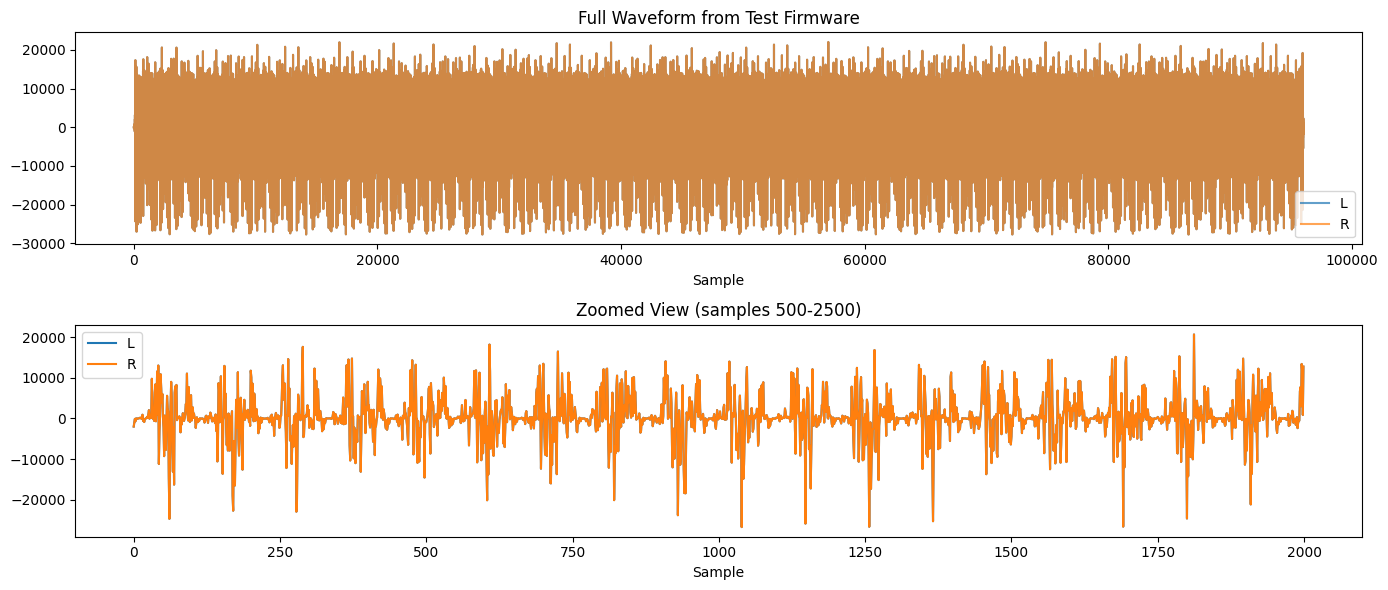

Sample rate: 48000 Hz
L channel: min=-27730, max=22059


In [67]:
# Analyze the test firmware output
import wave
import numpy as np
import matplotlib.pyplot as plt

with wave.open('/tmp/test_sam_output.wav', 'rb') as wav:
    sr = wav.getframerate()
    frames = wav.readframes(wav.getnframes())
    samples = np.frombuffer(frames, dtype=np.int16)
    
# Reshape to stereo
samples = samples.reshape(-1, 2)

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Full waveform
axes[0].plot(samples[:, 0], label='L', alpha=0.7)
axes[0].plot(samples[:, 1], label='R', alpha=0.7)
axes[0].set_title('Full Waveform from Test Firmware')
axes[0].legend()
axes[0].set_xlabel('Sample')

# Zoomed view (first 2000 samples after startup)
start = 500
end = 2500
axes[1].plot(samples[start:end, 0], label='L')
axes[1].plot(samples[start:end, 1], label='R')
axes[1].set_title(f'Zoomed View (samples {start}-{end})')
axes[1].legend()
axes[1].set_xlabel('Sample')

plt.tight_layout()
plt.savefig('test_firmware_output.png', dpi=100)
plt.show()

print(f"Sample rate: {sr} Hz")
print(f"L channel: min={samples[:,0].min()}, max={samples[:,0].max()}")

In [68]:
# Test the new assembler
import sys
sys.path.insert(0, '/home/jeff/bastel/mame/mame/sam8905')

from sam8905_assembler import (
    SAM8905Assembler, 
    make_dram_word, 
    make_amplitude_word,
    make_phase_increment
)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform

# Assemble the sinus oscillator
source = """
; Sinus Oscillator from SAM8905 Programmer's Guide
PHI=0
DPHI=1
AMP=2

RM      PHI,    <WA,WPHI,WSP>
RM      DPHI,   <WB>
RM      AMP,    <WXY,WSP>
RADD    PHI,    <WM>
RSP
                ,<WACC>
FIN
"""

asm = SAM8905Assembler(algorithm_size=32)
aram, errors = asm.assemble(source)

if errors:
    print("Errors:", errors)
else:
    print("Assembled successfully!")
    print(f"Instructions: {len(aram)}")
    print(f"First 6: {[f'0x{w:04X}' for w in aram[:6]]}")

# Create D-RAM for 440Hz sine
freq = 440
phase_inc = make_phase_increment(freq, 44100)
amplitude = 0x400  # Q0.11 amplitude
dram_slot0 = [0] * 16
dram_slot0[0] = 0  # PHI starts at 0
dram_slot0[1] = phase_inc << 7  # DPHI
dram_slot0[2] = make_amplitude_word(amplitude, mix_l=7, mix_r=7)  # AMP + mix

print(f"\nD-RAM for {freq}Hz:")
print(f"  D[0] = 0x{dram_slot0[0]:05X} (PHI)")
print(f"  D[1] = 0x{dram_slot0[1]:05X} (DPHI = {phase_inc})")
print(f"  D[2] = 0x{dram_slot0[2]:05X} (AMP + mix)")

Assembled successfully!
Instructions: 32
First 6: ['0x016F', '0x08BF', '0x11F7', '0x02DF', '0x06FF', '0x06FE']

D-RAM for 440Hz:
  D[0] = 0x00000 (PHI)
  D[1] = 0x01400 (DPHI = 40)
  D[2] = 0x2003F (AMP + mix)


Generated 2000 samples
L range: [-368, 367]
R range: [-368, 367]


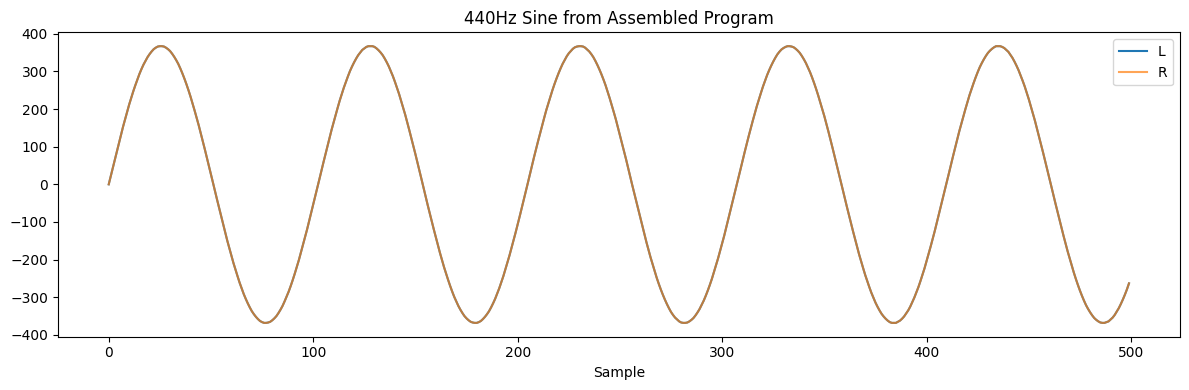

In [69]:
# Run the assembled program through the interpreter
sam = SAM8905Interpreter()
sam.load_aram(aram, offset=0)
sam.load_dram(0, dram_slot0)

# Generate samples
samples = sam.run(2000, active_slots=[0])

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(samples[:500, 0], label='L')
ax.plot(samples[:500, 1], label='R', alpha=0.7)
ax.set_title('440Hz Sine from Assembled Program')
ax.set_xlabel('Sample')
ax.legend()
plt.tight_layout()
plt.savefig('assembled_sine_output.png', dpi=100)
plt.show()